In [9]:
from IPython import get_ipython
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [566]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
import time
os.environ['HF_HOME'] = '/raid/xd/.cache/torch'
from types import MethodType
from tqdm import tqdm
from collections import defaultdict, OrderedDict, Counter, namedtuple
from datetime import datetime
from io import StringIO
from itertools import chain, product, combinations, cycle
import math
from functools import reduce, partial
from collections.abc import Iterable
import pickle, gzip

import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr

In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss
import torch.nn.functional as F 
from torch.utils.data.sampler import RandomSampler, Sampler, SequentialSampler
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim

# sys.path.insert(0, '/nas/xd/projects/transformers/src')
from transformers.data.data_collator import DataCollator, default_data_collator
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer, pipeline
from transformers import RobertaForMaskedLM, RobertaTokenizer, GPT2LMHeadModel, GPT2Tokenizer, GPTNeoForCausalLM
from transformers import T5Tokenizer, T5ForConditionalGeneration

from transformers.models.gpt2.modeling_gpt2 import GPT2Attention
from transformers.models.gpt_neo.modeling_gpt_neo import GPTNeoSelfAttention
from transformers.models.gptj.modeling_gptj import GPTJAttention, GPTJBlock
from transformers.models.xglm.modeling_xglm import XGLMAttention

from transformers import HfArgumentParser, Trainer, TrainingArguments, set_seed
# from transformers.trainer_utils import EvaluationStrategy

In [441]:
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA

In [12]:
import einops
from einops import rearrange

In [13]:
sys.path.insert(0, '/nas/xd/projects/pptree')
from pptree import Node, print_tree

In [26]:
from child_utils import *
from common_utils import *
from model_utils import *

In [16]:
models = {}
cache_dir = '/nas/xd/.cache/torch/transformers/'  # for models besides t5-3b/11b
proxies = {'http': '192.168.50.1:1081'} 

In [ ]:
# model_name = "EleutherAI/gpt-neo-1.3B"
for model_name in ['gpt2-large', 
            'gpt2-xl', 'EleutherAI/gpt-neo-1.3B',  # = babbage
            'EleutherAI/gpt-j-6B', 'KoboldAI/fairseq-dense-6.7B', # = curie 
            'KoboldAI/fairseq-dense-13B']:
    if model_name not in models:
        with Timer(model_name):
            model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=cache_dir)  
            tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
            models[model_name] = model, tokenizer

In [14]:
# model_name = 'gpt2-large'  # medium / large /xl
model_name = 'EleutherAI/gpt-j-6B' # gpt-j-6B, gpt-neo-1.3B/2.7B
model, tokenizer = models[model_name]
_ = model.eval()

masked_lm = tokenizer.mask_token is not None and len(tokenizer.additional_special_tokens) == 0
if masked_lm:
    mask_token = tokenizer.mask_token  # '<mask>' for roberta
elif len(tokenizer.additional_special_tokens) > 0:
    mask_token = tokenizer.additional_special_tokens[0]  # '<extra_id_0>' for t5
else:
    mask_token = ''  # for gpt2
if masked_lm: nlp = pipeline('fill-mask', model=model, tokenizer=tokenizer, top_k=5)

Using mask_token, but it is not set yet.


In [504]:
for block in model.transformer.h: _ = block.attn.to('cuda')
# _ = model.transformer.wte.to('cuda')

In [222]:
for block in model.transformer.h: _ = block.attn.to('cpu')
_ = model.transformer.wte.to('cpu')

In [23]:
unify(model)
blocks = model.transformer.h
attn = blocks[0].attn
ln_f = model.transformer.ln_f
L, H, embed_dim = len(blocks), attn.num_heads, attn.embed_dim

we = model.transformer.wte.weight.data
# wp = model.transformer.wpe.weight.t()
wu = model.lm_head.weight.data

In [25]:
# def T(f): return lambda x: f(x.T).T
mlp = lambda x: mlp_forward(blocks[0], x)
v = we.size(1) #// 2
# _we, _wu = we[:, :v], wu[:v]
# with torch.no_grad(): _e = mlp(_we.T) + _we.T

In [26]:
with torch.no_grad():
    _e = [we]
#     for b in blocks[:10]: _e.append(_e[-1] + mlp_forward(b, _e[-1]))
    for b in blocks[:1]: _e.append(_e[-1] + mlp_forward(b, _e[-1].to('cpu')).to(we.device))

In [165]:
a = o.attentions[12][0, 10]
sim = torch.einsum('lhij->lh', (torch.cat(o.attentions) + 1e-9).log() * a * torch.ones_like(a).tril())
list(zip(*topk_md(sim, 10)))

In [ ]:
list(zip(*topk_md(sim, 10)))

In [ ]:
l = 10
for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:1]:
    for k in range(H // 4):
        # print(layer, k * 2, k * 2 + 1)
        fig, axs = plt.subplots(1, 4, sharex=False, sharey=False, figsize=(20, 5))
        h = k * 4 + 0; plot_attn(o.attentions[l][0, h], tokens, ax=axs[0])
        h = k * 4 + 1; plot_attn(o.attentions[l][0, h], tokens, ax=axs[1])
        h = k * 4 + 2; plot_attn(o.attentions[l][0, h], tokens, ax=axs[2])
        h = k * 4 + 3; plot_attn(o.attentions[l][0, h], tokens, ax=axs[3])

## Amplification

In [620]:
def test(model, data_tuples, verbose=False, **kwargs):
    losses = []
    for data_tuple in data_tuples[:]:
        text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr = data_tuple[:]
        loss, _ = show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t', verbose=verbose)
        if verbose: print('loss =', loss)
        
        from_layer, _ = kwargs['special_head']  # 12
        hidden_states = o.hidden_states[from_layer]
        o2 = forward(model, inputs, labels=labels, attribute_layer=from_layer, hidden_states=hidden_states, **kwargs)
        loss2, _ = show_predictions(text, examples, tokenizer, o2.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t', verbose=verbose)
        if verbose: print('loss2 =', loss2, '\n')
        losses.append(loss2.item())
    losses = torch.Tensor(losses)
    print('losses =', losses)
    return losses.mean()

In [ ]:
12-10*3,
0.47

12-10*3, threshold=5., base_multiplier=1.5
tensor([0.0230, 0.0119, 1.2052, 0.2945, 0.0157, 0.0597, 0.0702, 0.5085, 0.2899,
        0.0326, 0.0408, 1.1831, 0.0516, 0.6363, 0.5234, 2.5790, 0.0979, 0.5943])
tensor(0.4565)
12-10*3, threshold=3., base_multiplier=1.5
tensor([0.0227, 0.0109, 1.2108, 0.2642, 0.0151, 0.0506, 0.0595, 0.5087, 0.3540,
        0.0263, 0.0336, 1.1175, 0.0426, 0.7020, 0.5188, 2.5127, 0.0997, 0.4610])
tensor(0.4450)
12-10*3, threshold=1., base_multiplier=1.5
tensor([0.0216, 0.0131, 1.2596, 0.3078, 0.0212, 0.0453, 0.0745, 0.7034, 0.2971,
        0.0242, 0.0579, 0.9990, 0.0391, 0.7800, 0.4985, 2.7309, 0.1179, 0.4555])
tensor(0.4693)

12-10*1, threshold=5., base_multiplier=1.5
tensor([0.0280, 0.0179, 1.5402, 0.6329, 0.0368, 0.1095, 0.1551, 0.9999, 0.4408,
        0.0323, 0.0402, 0.8825, 0.0553, 0.5654, 0.6607, 2.1981, 0.1345, 0.7474])
tensor(0.5154)
12-10*1, threshold=10., base_multiplier=1.5
tensor([0.0276, 0.0188, 1.5444, 0.5967, 0.0475, 0.0998, 0.1569, 1.0300, 0.4510,
        0.0330, 0.0390, 0.8318, 0.0685, 0.6363, 0.7036, 2.2156, 0.1415, 0.7441])
tensor(0.5214)
12-10*1, threshold=10., base_multiplier=2.0
tensor([0.0272, 0.0174, 1.5211, 0.5767, 0.0467, 0.0894, 0.1517, 0.9618, 0.4449,
        0.0375, 0.0390, 0.8318, 0.0626, 0.6357, 0.7095, 2.2156, 0.1410, 0.7165])
tensor(0.5126)

12-10*3, threshold=5., base_multiplier=1.5 opt
tensor([0.0239, 0.0128, 1.1290, 0.2517, 0.0170, 0.0526, 0.0707, 0.5806, 0.3219,
        0.0238, 0.0440, 0.9224, 0.0427, 0.7748, 0.5562, 2.6125, 0.1175, 0.4395])
tensor(0.4441)

8-1*1, threshold=5., base_multiplier=1.5 opt
tensor([0.0287, 0.0160, 1.5901, 0.6175, 0.0296, 0.0746, 0.1242, 0.9194, 0.5042,
        0.0330, 0.0492, 0.7875, 0.0552, 0.6154, 0.6522, 2.2360, 0.1363, 0.6757])
tensor(0.5080)

In [ ]:
test(model, data_tuples, special_head=(12, 10), wv=wv1, wo=wo1*0, special_head_multiplier=2.,
    multiplied_layers=range(13, L), attr_threshold=5., base_multiplier=1.5, verbose=True)

In [ ]:
label_mask = (labels != -100).squeeze(0)#.fill_(1)
for layer in range(13, L):
    block = blocks[layer]
    mask = torch.ones(1, H, L, H + 2, o.cat_hidden_states.size(-2)); mask[:, :, layer:] = 0 # bnloi
    x = {'mask': mask}  
    attn_labels = torch.einsum('bnij,bnj->bnij', o.attentions[layer],
                    o.head_inputs[layer].norm(dim=-1)) # bnje->bnj
    attn_labels = attn_labels / attn_labels.sum(-1, keepdim=True)  # bnij->bni1
    fwd_fn = partial(cat_attn_forward, cat_hidden_states=o.cat_hidden_states, 
                sum_hidden_states=o.hidden_states[layer], attn_labels=attn_labels)
    attr, ys, logits = _attribute(fwd_fn, block, x, num_points=3)
    # print(ys)

    a = attr['mask']  # nloi
    # a = a[:, :, :, label_mask] # nloi->nlok
    a2 = torch.add(a[:, 8, 1, :], a[:, 12, 10, :]) # nk
    if a2[:, label_mask].max() > 1:
        print('layer', layer)
        _a2 = a2.clone(); _a2[0, 0] = 1; _ = sns.heatmap(_a2 * (_a2 >= 1) * label_mask); plt.show()
        print((_a2 * (_a2 >= 1) * label_mask).view(-1).topk(5)[0])
        for head in range(H):
            if a2[head].max() > 1:
                print(f'{layer}-{head}')
                plot_attn(o.attentions[layer][0, head], tokens); plt.show()

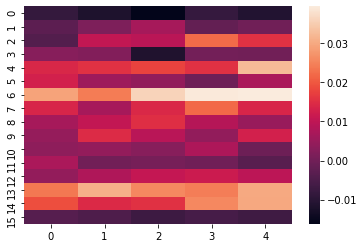

In [ ]:
a = attr['mask']  # nloi
a = a[:, :, :, (labels != -100).squeeze(0)] # nloi->nlok
ratio = ((a[:, 8, 1, :] + a[:, 12, 10, :]) / torch.einsum('nlok->nk', a.abs()))
b = einops.reduce(a, 'n l o k -> n k', 'max') == torch.maximum(a[:, 8, 1, :], a[:, 12, 10, :])
_ = sns.heatmap(ratio)
head_output_norm = o.head_outputs[layer][0, :, (labels != -100).squeeze(0)].norm(dim=-1)
_ = sns.heatmap(head_output_norm)

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio:  
$||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

$||W_{QK}^{h_2}W_{OV}^{h_1}W_{OV}^{h_0}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F ||W_{OV}^{h_0}||_F)$

In [140]:
def v_comp(WOV, l0, h0, l1, h1): return ((WOV[l1][h1] @ WOV[l0][h0]).norm() / WOV[l1][h1].norm() / WOV[l0][h0].norm()).item()
def q_comp(WQK, WOV, l0, h0, l1, h1): return ((WQK[l1][h1] @ WOV[l0][h0]).norm() / WQK[l1][h1].norm() / WOV[l0][h0].norm()).item()
def vq_comp(WQK, WOV, l0, h0, l1, h1, l2, h2):
    return ((WQK[l2][h2] @ WOV[l1][h1] @ WOV[l0][h0]).norm() / WQK[l2][h2].norm() / WOV[l1][h1].norm() / WOV[l0][h0].norm()).item()

In [ ]:
WQK = [[combine_weights(get_head_weights(model, l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(model, l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]
WQKN = [[WQK[l][h].norm() for h in range(H)] for l in tqdm(range(L))]
WOVN = [[WOV[l][h].norm() for h in range(H)] for l in tqdm(range(L))]

In [ ]:
vq_comps = np.zeros((H, H))
nvq_comps = np.zeros((H, H))
l1, h1 = 12, 10
for l0 in range(3, 4):
    for h0 in tqdm(range(H)):
        # print(f'{l0}-{h0}', end=' ')
        wov01 = WOV[l1][h1] @ WOV[l0][h0]
        # norm01 = WOV[l1][h1].norm() * WOV[l0][h0].norm()
        norm01 = WOVN[l1][h1] * WOVN[l0][h0]
        for l2 in range(13, 14):
            for h2 in range(H):
                vq_comps[h0, h2] = (WQK[l2][h2].T @ wov01).norm() #/ WQKN[l2][h2] / norm01
                nvq_comps[h0, h2] = vq_comps[h0, h2] / WQKN[l2][h2] / norm01
    # print()
tensor = torch.Tensor(vq_comps)
values, indices = tensor.flatten().topk(10)
list(zip(values, *np.unravel_index(indices.numpy(), tensor.shape)))

## Head geometry visualization

In [15]:
def add_ws(model, ws, w2i, w_type, start_layer, end_layer, H):
    offset = len(w2i)
    dL = end_layer - start_layer
    n_ws = dL * H
    w_types = [w_type] * n_ws
    layers, heads = np.unravel_index(range(n_ws), (dL, H))
    layers = layers + start_layer
    w2i.update(OrderedDict(zip(
        zip(w_types, layers, heads),  # key, e.g. ('o', 2, 11)
        range(offset, offset + n_ws))))  # value, e.g. 0+43
    w_idx, transpose = ['q', 'k', 'v', 'o'].index(w_type), w_type == 'o'
    _ws = torch.cat([get_head_weights(model, l, transpose=transpose)[w_idx] for l in range(start_layer, end_layer)])  # l*nde->(ln)de
    ws = _ws if ws is None else torch.cat([ws, _ws])
    return ws, w2i

In [369]:
ws, w2i = None, OrderedDict()
ws, w2i = add_ws(model, ws, w2i, 'o', 0, 13+1, H)
ws, w2i = add_ws(model, ws, w2i, 'q', 9, L, H)
ws, w2i = add_ws(model, ws, w2i, 'v', 8, 13+1, H)

In [370]:
_distance, distance = get_affinities(ws, ws)
tsne = TSNE(n_components=2, metric='precomputed')
result = tsne.fit_transform(_distance)

In [ ]:
# _ = plt.figure(figsize=(20, 10))
fig, ax = plt.subplots(figsize=(20, 10))

for cond, color in [([i for (m_type, l, h), i in w2i.items() if m_type == 'o' and l < 8], 'g'),
                    ([i for (m_type, l, h), i in w2i.items() if m_type == 'q' and 12 < l < 24], 'r')]:
    _ = plt.scatter(x=result[:, 0][cond], y=result[:, 1][cond], marker='.', color=color)
# _ = ax.scatter(x=result[:, 0], y=result[:, 1], marker='.')

for w_type, l, h in [('v', 12, 10), ('v', 8, 1), ('v', 8, 0), ('v', 8, 15), ('v', 11, 1),
                    ('o', 12, 10), ('o', 8, 1), ('o', 8, 0), ('o', 8, 15), ('o', 11, 1)]:
    i = w2i[(w_type, l, h)]
    _ = ax.annotate(f'{w_type}-{l}-{h}', (result[i, 0], result[i, 1]), color='g' if w_type == 'v' else 'r')

In [751]:
def T(eigvs): # k=2
    # assert eigvs.ndim in [3, 5], str(eigvs.size())
    return rearrange(eigvs, 'l0 n0 l1 n1 k -> l1 n1 l0 n0 k') #\
        # if eigvs.ndim == 5 else rearrange(eigvs, 'ln0 ln1 k -> ln1 ln0 k')

In [954]:
k = 2
use_reality = True

In [747]:
# B = b = 2, k = 2
eigvs4 = rearrange([
    rearrange([eigvs.voov, eigvs.qkov], 'b l0 n0 l1 n1 k -> l0 n0 b l1 n1 k'),
    rearrange([T(eigvs.qkov), eigvs.qkkq], 'b l0 n0 l1 n1 k -> l0 n0 b l1 n1 k')
], 'B l0 n0 b l1 n1 k -> B l0 n0 b l1 n1 k')

In [1040]:
ov_mask = einops.repeat(torch.BoolTensor([True, False]), 'b -> b l n', l=L, n=H)
qk_mask = einops.repeat(torch.BoolTensor([False, True]), 'b -> b l n', l=L, n=H)
# gt_l0_mask = einops.repeat(torch.ones(L, L) - torch.tril(torch.ones(L, L)) * 1, 'l0 l1 ->l0 n0 l1 n1 k', n0=H, n1=H, k=2).bool()
gt_l0_mask = einops.repeat(torch.ones(L, L) - torch.tril(torch.ones(L, L)) * 1, 'l0 l1 ->l0 n0 l1 n1', n0=H, n1=H).bool()
# tensor2mat = 'B l0 n0 b l1 n1 k -> (B l0 n0) (b l1 n1) k'
def layer_mask(l): mask = torch.zeros(L, 1).bool(); mask[l] = True; return mask

In [1064]:
mask = ov_mask & layer_mask(range(1, 14)) | qk_mask & layer_mask(range(3, 14))
# einsum is the simpliest way of doing this
_eigvs4= eigvs4[torch.einsum('akg,blh->akgblh', mask, mask)]  # (blnbln) k, b=2,k=2
lh = int(math.sqrt(_eigvs4.size(0)))
_eigvs4 = _eigvs4.view(lh, lh, _eigvs4.size(-1)) # (bln) (bln) k

_result = embed_by_pairwise_eigvs(_eigvs4[:, :, int(use_reality)])
result = torch.ones(2, L, H, 2) * float('nan')
result[mask] = torch.Tensor(_result)

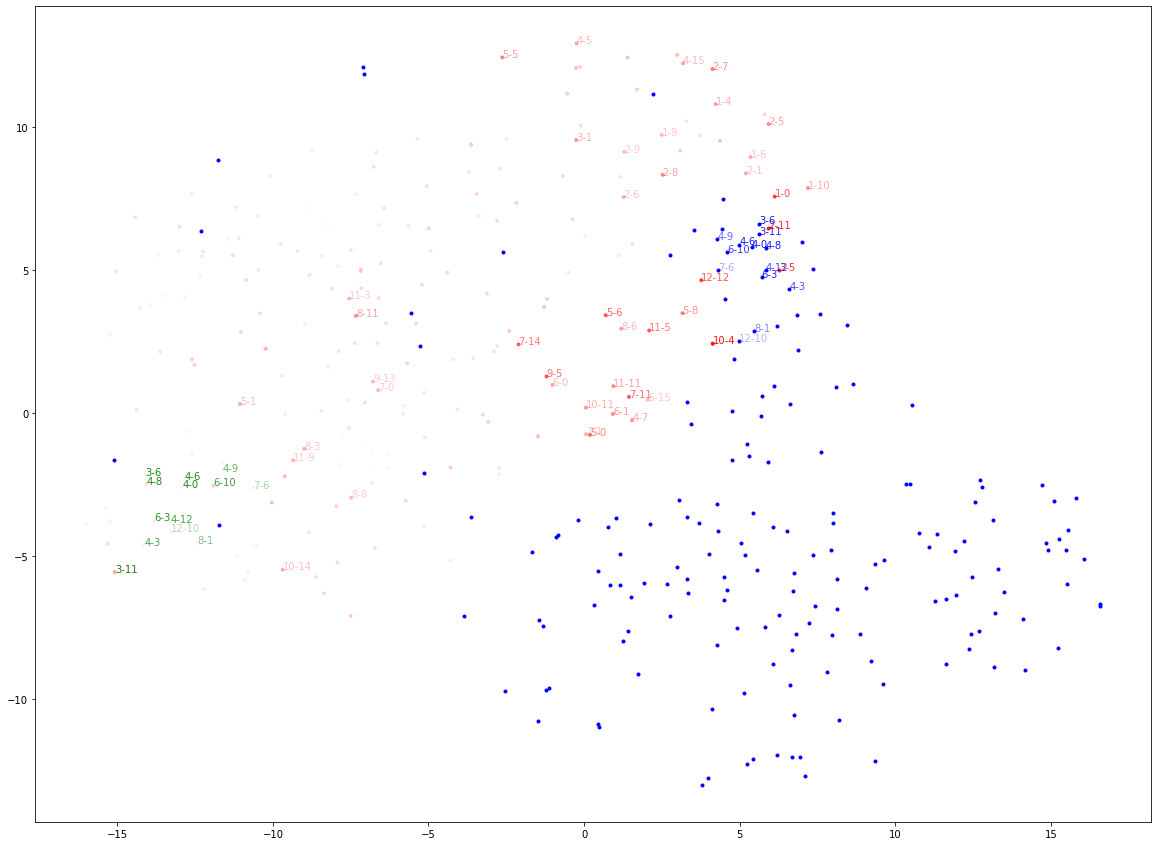

In [1092]:
fig, ax = plt.subplots(figsize=(20, 15))
_ = plt.scatter(*tuple(result[mask & ov_mask].T), marker='.', color='r', alpha=pos_score[mask[0]])
_ = plt.scatter(*tuple(result[mask & qk_mask].T), marker='.', color='b')
# _ = plt.scatter(*tuple(result[mask & ov_mask & layer_mask(range(1, 2))].T), marker='.', color='c')
cond, color = ov_mask & (pos_score > 0.2), 'r'
for b, l, h in (mask & cond).nonzero(): _ = ax.annotate(f'{l}-{h}', result[b, l, h], color=color, alpha=pos_score[l, h].item())
# for l, h in product(range(7, 14), range(H)): _ = ax.annotate(f'{l}-{h}', result[1, l, h], color='k')
# for b, l, h in (mask & qk_mask).nonzero(): _ = ax.annotate(f'{l}-{h}', result[b, l, h], color='b')
for (l, h), v in get_knn(eigvs.qkov[..., int(use_reality)] * gt_l0_mask, [(2, 11), (3, 5)]).items():
    _ = ax.annotate(f'{l}-{h}', result[1, l, h], color='b', alpha=rescale(v, 0.9))
    _ = ax.annotate(f'{l}-{h}', result[0, l, h], color='g', alpha=rescale(v, 0.9))

In [934]:
top_pos_heads = [(2, 11), (3, 5), (12, 12), (10, 4)]

In [ ]:
l0, h0 = 12, 12
topk_md(eigvs.voov[l0, h0, :, :, 1], 10)

In [1062]:
l, h = 13, 13
topk_md((eigvs.qkov[..., int(use_reality)] * gt_l0_mask)[:, :, l, h], 10)

(array([11, 10,  7, 11, 12, 10,  6,  9,  8,  5]),
 array([11, 11, 11,  5, 12,  4,  1,  5, 12,  5]),
 array([0.97314453, 0.94140625, 0.9326172 , 0.93066406, 0.9272461 ,
        0.9038086 , 0.90185547, 0.8964844 , 0.88183594, 0.86376953],
       dtype=float32))

## Affinity analysis

In [ ]:
_affinities = torch.zeros((L, L, H, H))
affinities = torch.zeros((L, L, H, H))
for l0 in tqdm(range(0, l1)):
    for l2 in range(l1 + 1, L):
        if True:
        # with Timer(f'layer{l0}-layer{l2}'):
            wv0, wo0 = get_head_weights(model, l0, transpose=True)[2:]
            wq2, wk2 = get_head_weights(model, l2, transpose=True)[:2]
            wv0, wo0, wq2, wk2 = wv0.to('cuda'), wo0.to('cuda'), wq2.to('cuda'), wk2.to('cuda')
            with torch.no_grad():
                a, na = get_affinities3(wv0 @ wo0, _wvo, wq2 @ wk2.transpose(-2, -1))
            a, na = a.to('cpu'), na.to('cpu')
            _affinities[l0, l2] = a.squeeze(1)  # m1o->mo
            affinities[l0, l2] = na.squeeze(1)  # m1o->mo

_affinities, affinities = rearrange(_affinities, 'k l m n -> k m l n'), rearrange(affinities, 'k l m n -> k m l n')
np.savez_compressed(f'affinities{l1}-{h1}.npz', a=_affinities.numpy(), na=affinities.numpy())

In [ ]:
data = np.load(f'affinities{l1}-{h1}.npz')
affinities = torch.Tensor(data['na'])
# topk_md(torch.einsum('kmln->km', affinities), 20)  # klmn->km/ln
# fig, ax = plt.subplots(figsize=(20, 10))
# _ = sns.heatmap(rearrange(affinities[: l1, :, l1 + 1: L], 'l0 h0 l2 h2 -> (l0 h0) (l2 h2)'), ax=ax)

In [ ]:
[(l, h, v, eigv_positivity[l, h]) for l, h, v in zip(*topk_md(torch.einsum('kmln->ln', affinities), 10))]

In [ ]:
[(l, h, v, eigv_positivity[l, h], k_comp_max[l, h]) for l, h, v in zip(*topk_md(torch.einsum('kmln->km', affinities), 20))]

In [263]:
[((l, h), count, eigv_positivity[l, h]) for (l, h), count in Counter(
    zip(*np.unravel_index(affinities.view(-1).topk(200).indices, affinities.size())[:2])).most_common()]

[((8, 13), 53, tensor([-0.7326, -0.3432])),
 ((8, 7), 50, tensor([0.1159, 0.1454])),
 ((6, 2), 35, tensor([ 0.1564, -0.6046])),
 ((10, 7), 18, tensor([0.6215, 0.6954])),
 ((10, 4), 17, tensor([-0.6122,  0.1375])),
 ((4, 1), 11, tensor([-0.5152, -0.4199])),
 ((3, 6), 9, tensor([-0.6699,  0.8540])),
 ((4, 6), 2, tensor([-0.8550,  0.8804])),
 ((3, 12), 1, tensor([-0.4500,  0.2134])),
 ((5, 4), 1, tensor([-0.7971,  0.2454])),
 ((1, 7), 1, tensor([0.9189, 0.0250])),
 ((6, 10), 1, tensor([-0.6924,  0.9326])),
 ((7, 9), 1, tensor([-0.4489, -0.3285]))]

In [ ]:
for l0, h0, l2, h2 in zip(*np.unravel_index(affinities.view(-1).topk(100).indices, affinities.size())):
    if True: #(l0, h0) == (8, 7) and (l2, h2) == (22, 5):
        wv0, wo0 = get_head_weights(model, l0, h0, transpose=True)[2:]
        wq2, wk2 = get_head_weights(model, l2, h2, transpose=True)[:2]
        q, kT = (wv0 @ wo0 @ wv1 @ wo1 @ wq2), wk2.T
        eigv_pos = plot_eigv((kT @ q).eig()[0], plot=False)
        print(f'{l0}-{h0}, {l2}-{h2}', eigv_pos, eigv_positivity[l2, h2])

In [207]:
na0 = get_ov_affinities(model, l1, wv1, wo1, range(l1))

In [208]:
[(i, f'{l0}-{h0}', k_comp_max[l0, h0], eigv_positivity[l0, h0], pos_heads2val.get((l0, h0)))
    for i, (l0, h0) in enumerate(zip(*topk_md(na0, 10)[:2]))]

[(0, '10-4', tensor(0.4164), tensor([-0.6122,  0.1375]), 0.93680805),
 (1, '8-13', tensor(0.2575), tensor([-0.7326, -0.3432]), None),
 (2, '6-2', tensor(0.5317), tensor([ 0.1564, -0.6046]), None),
 (3, '8-7', tensor(0.6832), tensor([0.1159, 0.1454]), None),
 (4, '4-1', tensor(0.0876), tensor([-0.5152, -0.4199]), None),
 (5, '10-7', tensor(0.7886), tensor([0.6215, 0.6954]), None),
 (6, '3-6', tensor(0.9708), tensor([-0.6699,  0.8540]), None),
 (7, '6-15', tensor(0.2413), tensor([-0.6973, -0.5122]), None),
 (8, '3-12', tensor(0.8777), tensor([-0.4500,  0.2134]), None),
 (9, '6-7', tensor(0.8805), tensor([0.2228, 0.7724]), None)]

In [385]:
n_heads2=40
na2 = get_qk_affinities(model, l1, wv1, wo1, range(l1 + 1, L))
heads2 = list(zip(*topk_md(na2, n_heads2)[:2]))
# heads2 = [(3, 11), (8, 1), (12, 10), (13, 13), (14, 6), (15, 7), (16, 7)]
# heads2 = [(13, 2), (14, 6), (16, 6)]

In [392]:
for l0, h0 in heads0:
    wq0, wk0 = get_head_weights(model, l0, h0, transpose=True)[:2]
    ln0 = blocks[l0].ln_1
    print(l0, h0, eigv_positivity[l0, h0], get_eigv_pos(wk0.T @ wq0), get_eigv_pos((_e[1] @ wk0).T @ (_e[1] @ wq0)), get_eigv_pos((ln0(_e[1]) @ wk0).T @ (ln0(_e[1]) @ wq0)))

1 7 tensor([0.9189, 0.0250]) 0.9083833694458008 0.9335801601409912 0.9189456105232239
3 9 tensor([ 0.8335, -0.2831]) 0.9482325315475464 0.9819193482398987 0.833528995513916
6 2 tensor([ 0.1564, -0.6046]) 0.8087643384933472 0.533660352230072 0.15639112889766693
6 7 tensor([0.2228, 0.7724]) 0.5011569857597351 0.79461270570755 0.2227814495563507
8 7 tensor([0.1159, 0.1454]) 0.5051772594451904 0.8258638381958008 0.11588381230831146
10 7 tensor([0.6215, 0.6954]) 0.6630171537399292 0.886583685874939 0.6215054988861084


In [ ]:
add_attr(topk_md(na0, 100, zipped=True), [eigv_positivity_noln[:, :, [0, 2]], pos_score, k_comp_wmean])

In [774]:
# n_heads0=20
# na0 = get_qk_affinities(model, l1, wv1, wo1, range(l1 + 1, L))
# na0 = get_ov_affinities(model, l1, wv1, wo1, range(l1))
# heads0 = list(zip(*topk_md(na0, n_heads0)[:2]))
heads0 = [(3, 6), (3, 11), (4, 8), (6, 10)]
# heads0 = [(4, 1), (6, 15), (8, 13), (10, 1)]  # eigv_pos012 < -0.8
# heads0 = [(3, 6), (3, 12), (4, 6), (4, 0), (6, 10), (8, 1)] # k_comp_wmean > 0.2
# heads0 = [(1, 7), (3, 9), (6, 2), (6, 7), (8, 7), (10, 7)] # k_comp_wmean < 0.2 and eigv_pos > 0, i.e. the good ones
heads2 = [(13, 2), (14, 6)]

In [776]:
eigv_pos012 = compute_eigv_pos012(model, l1, h1, wv1, wo1, heads0, heads2,
    eigv_positivity, heads_1=None, use_ln=True, _e=_e[0], verbose=True)

3-6, 12-10, 13-2 0.5348938703536987 0.09096379578113556 tensor([0.0715, 0.9286])
3-6, 12-10, 14-6 0.34743404388427734 -0.6888074278831482 tensor([-0.3117,  0.8779])
3-11, 12-10, 13-2 -0.04069763794541359 -0.8281253576278687 tensor([0.0715, 0.9286])
3-11, 12-10, 14-6 -0.12515242397785187 -0.704781711101532 tensor([-0.3117,  0.8779])
4-8, 12-10, 13-2 0.42304927110671997 0.5700580477714539 tensor([0.0715, 0.9286])
4-8, 12-10, 14-6 0.17858581244945526 -0.5553858280181885 tensor([-0.3117,  0.8779])
6-10, 12-10, 13-2 0.7705729603767395 0.9151273369789124 tensor([0.0715, 0.9286])
6-10, 12-10, 14-6 0.11901864409446716 0.739040195941925 tensor([-0.3117,  0.8779])


In [783]:
del compute_eigv_pos012
from model_utils import compute_eigv_pos012

In [786]:
eigv_pos012 = compute_eigv_pos012(model, l1, h1, wv1, wo1, [(6, 10)], heads2,
    eigv_positivity, heads_1=[(5, 1)], use_ln=True, _e=_e[0], verbose=True)

6-10, 12-10, 13-2 0.0015929696382954717 -0.672815203666687 tensor([0.0715, 0.9286])
6-10, 12-10, 14-6 0.20985731482505798 -0.4981975853443146 tensor([-0.3117,  0.8779])


In [747]:
l1, h1 = 12, 10; wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]

In [773]:
add_attr([(l0, h0, l2, h2, torch.Tensor(eigv_pos)) for (l0, h0, l2, h2), eigv_pos in eigv_positivity012[l1, h1].items()
    if pos_score[l0, h0] < 0.2 and k_comp_wmean_ln[l0, h0] > 0.2], eigv_positivity_noln)

[[3, 6, 14, 6, tensor([ 0.3474, -0.6888]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 25, 9, tensor([ 0.4780, -0.1603]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 21, 8, tensor([ 0.3771, -0.2857]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 22, 14, tensor([ 0.3669, -0.4061]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 21, 13, tensor([ 0.3801, -0.6308]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 22, 7, tensor([ 0.3632, -0.4893]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 22, 5, tensor([ 0.4398, -0.1849]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 22, 4, tensor([ 0.4249, -0.7504]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 24, 11, tensor([ 0.3495, -0.5307]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 22, 9, tensor([ 0.3915, -0.6159]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 23, 15, tensor([ 0.4113, -0.8320]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 23, 13, tensor([ 0.2991, -0.8453]), tensor([0.0104, 0.3343, 0.8544])],
 [3, 6, 21, 6, tensor([ 0.3622, -0.0279]), tensor([0.0104, 

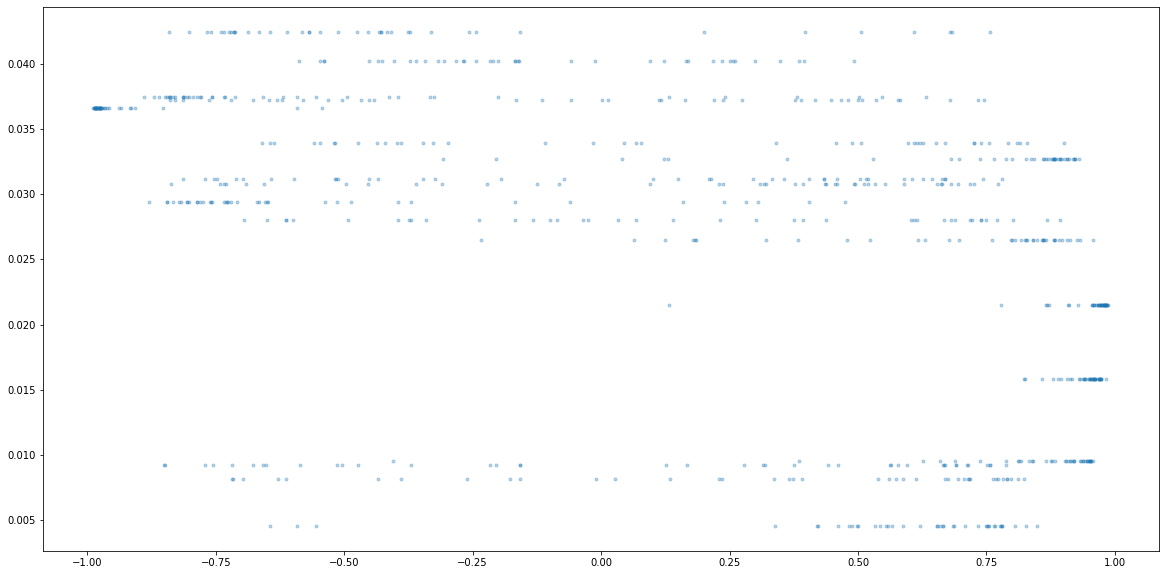

In [810]:
x, y = zip(*[(eigv_pos[1], pos_score[l0, h0]) for (l0, h0, l2, h2), eigv_pos in eigv_positivity012[l1, h1].items()
    if pos_score[l0, h0] < 0.045 and k_comp_wmean_ln[l0, h0] < 0.2])
_ = plt.figure(figsize=(20, 10)); _ = plt.scatter(x, y, marker='.', alpha=0.3)

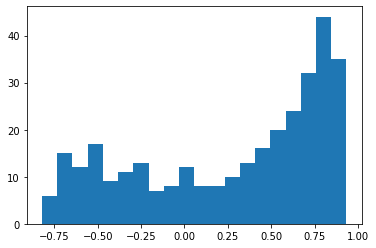

In [806]:
_ = plt.hist(x, bins=20)

In [665]:
n_intermediary_heads = 100
# n_heads0, n_heads2 = 20, 40  # gpt2-large
# n_heads0, n_heads2 = 15, 30  # gpt-j
n_heads0, n_heads2 = 100, 40  # gpt-j
# eigv_positivity012 = {}
# maybe_intermediary_heads = list(zip(*topk_md(k_comp_max, n_intermediary_heads)[:2]))
# maybe_intermediary_heads = [(l1, h1) for l1, h1 in maybe_intermediary_heads if 0 < l1 < L - 1]
maybe_intermediary_heads = [(12, 10)] # [(8, 1), (13, 13)]
# maybe_intermediary_heads = list(zip(*topk_md(conductivity, 20)[:2]))
for l1, h1 in (maybe_intermediary_heads):
    wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]
    na0 = get_ov_affinities(model, l1, wv1, wo1, range(l1))
    heads0 = list(zip(*topk_md(na0, n_heads0)[:2]))
    na2 = get_qk_affinities(model, l1, wv1, wo1, range(l1 + 1, L))
    heads2 = list(zip(*topk_md(na2, n_heads2)[:2]))
    eigv_pos012 = compute_eigv_pos012(model, l1, h1, wv1, wo1, heads0, heads2, 
        eigv_positivity, use_ln=True, _e=_e[0], verbose=False)
    eigv_positivity012[l1, h1] = eigv_pos012

100%|██████████| 100/100 [16:07<00:00,  9.68s/it]


In [ ]:
eigv_positivity012_ln = eigv_positivity012

In [68]:
# with gzip.open(f'eigv_positivity012_{model_name.split("/")[-1]}.pkl.gz', 'wb') as f:
#     pickle.dump(eigv_positivity012, f)
with gzip.open(f'eigv_positivity012_{model_name.split("/")[-1]}.pkl.gz', 'rb') as f:
    eigv_positivity012 = pickle.load(f)

In [852]:
conductivity = torch.zeros(L, H)
for l, h in eigv_positivity012:
    conductivity[l, h] = get_conductivity(eigv_positivity012, l, h)

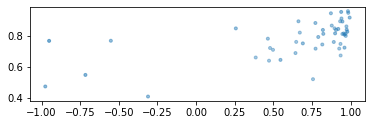

In [259]:
names, affinity_val, eigv_pos_ov, k_comp = zip(*[(f'{l}-{h}', v, eigv_positivity[l, h, 1].item(), k_comp_max[l, h].item()) 
        for l, h, v in zip(*topk_md(na2, 50))])
# plt.figure(figsize=(16, 10))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.scatter(x=eigv_pos_ov, y=k_comp, marker='.', alpha=affinity_val)

## Positional heads & K-compositions

In [ ]:
plt.figure(figsize=(10, 10))
plt.gca().set_aspect('equal', adjustable='box')
_ = plt.scatter(x=eigv_positivity[:, :, 1].view(-1), y=k_comp_max.view(-1), marker='.')#, alpha=affinity_val)

In [225]:
pos_score = get_positional_score(model)

In [ ]:
positional_heads = topk_md(pos_score, 60, zipped=True) # 60 for gpt-j
positional_heads = sorted(positional_heads, key=lambda x: x[-1], reverse=True)  # sorted by value
positional_heads = sorted(positional_heads, key=lambda x: x[0]) # then by layer
positional_heads
pos_heads2val = OrderedDict(((l, h), v) for l, h, v in positional_heads)

In [ ]:
for l, h, v in sorted(positional_heads, key=lambda x: x[-1], reverse=True):
    wv, wo = get_head_weights(model, l, h, transpose=True)[2:]
    print(f'{l}-{h}', v, eigv_positivity[l, h], get_eigv_pos(wo @ wv))

In [606]:
l1, h1 = 12, 10; wv1, wo1 = get_head_weights(model, l1, h1, transpose=False)[2:]

In [717]:
# all_heads = [(l, h) for l in range(l1//2, l1) for h in range(H)]
heads0 = [(l, h) for l, h, _ in positional_heads]
# heads0 = set(all_heads) - set(heads0)

In [718]:
wvs0, wos0 = zip(*[get_head_weights(model, l, h, transpose=True)[2:] for l, h in heads0])
wvs0 = rearrange(list(wvs0), 'b e d -> b e d')
wos0 = rearrange(list(wos0), 'b d e -> b d e')
# heads0_outputs = rearrange([blocks[l].ln_1(_e[1]) for l, _ in heads0], 'b v e -> b v e')
heads0_outputs = rearrange([_e[0] for l, _ in heads0], 'b v e -> b v e')
heads0_outputs = heads0_outputs @ wvs0 @ wos0  # bve,bed,bde->bve

In [720]:
k_compositions = torch.zeros(L, H, len(heads0))
for l1 in tqdm(range(L)):
    # ln_e = blocks[l1].ln_1(_e[1])
    # ln_heads0_outputs = blocks[l1].ln_1(heads0_outputs)
    ln_e = _e[0]
    ln_heads0_outputs = heads0_outputs
    for h1 in range(H):
        if l1 == 0:
            eigv_pos = [0. for _ in range(len(heads0))]
        else:
            wq1, wk1, wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)
            q = ln_e @ wq1
            k = ln_heads0_outputs @ wk1
            M = k.transpose(-2, -1) @ q   # bdv,vd->bdd
            eigv_pos = [get_eigv_pos(m) for m in M]
            eigv_pos = [ep if l < l1 else 0. for ep, (l, _) in zip(eigv_pos, heads0)]
        k_compositions[l1, h1] = torch.Tensor(eigv_pos)

100%|██████████| 28/28 [59:54<00:00, 128.37s/it]


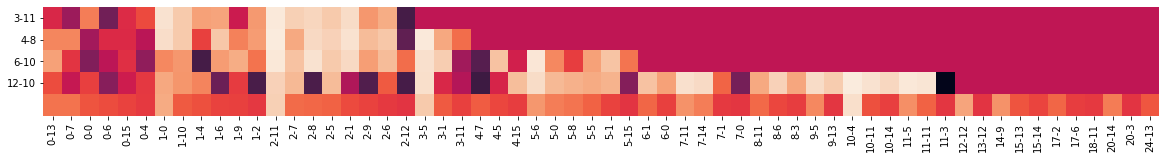

In [1509]:
plot_k_comp([(3, 11), (4, 8), (6, 10), (12, 10)], k_compositions_noln, pos_heads2val)

In [206]:
# with torch.no_grad(): sim_eigv_pos, sim_eigv_real = compute_sim_eigv(model, L, H, weA=_e[0])
with torch.no_grad(): sim_eigv_pos_weNone, sim_eigv_real_weNone = compute_sim_eigv(model, L, H)
with torch.no_grad(): sim_eigv_pos_we1, sim_eigv_real_we1 = compute_sim_eigv(model, L, H, weA=_e[1])

 14%|█▍        | 4/28 [11:29<1:07:47, 169.49s/it]

In [202]:
np.savez_compressed(f'sim_eigv_we0_{model_name.split("/")[-1]}.npz', sim_eigv_pos=sim_eigv_pos, sim_eigv_real=sim_eigv_real)
np.savez_compressed(f'sim_eigv_weNone_{model_name.split("/")[-1]}.npz', sim_eigv_pos=sim_eigv_pos_weNone, sim_eigv_real=sim_eigv_real_weNone)
np.savez_compressed(f'sim_eigv_we1_{model_name.split("/")[-1]}.npz', sim_eigv_pos=sim_eigv_pos_we1, sim_eigv_real=sim_eigv_real_we1)

In [722]:
eigvs.voov = torch.cat([
    rearrange(sim_eigv_pos_weNone, '(l0 h0) (l1 h1) -> l0 h0 l1 h1 1', l0=L, h0=H, l1=L, h1=H),
    rearrange(sim_eigv_real_weNone, '(l0 h0) (l1 h1) -> l0 h0 l1 h1 1', l0=L, h0=H, l1=L, h1=H)
], dim=4)
eigvs.evoove = torch.cat([
    rearrange(sim_eigv_pos, '(l0 h0) (l1 h1) -> l0 h0 l1 h1 1', l0=L, h0=H, l1=L, h1=H),
    rearrange(sim_eigv_real, '(l0 h0) (l1 h1) -> l0 h0 l1 h1 1', l0=L, h0=H, l1=L, h1=H)
], dim=4)
eigvs.EvoovE = torch.cat([
    rearrange(sim_eigv_pos_we1, '(l0 h0) (l1 h1) -> l0 h0 l1 h1 1', l0=L, h0=H, l1=L, h1=H),
    rearrange(sim_eigv_real_we1, '(l0 h0) (l1 h1) -> l0 h0 l1 h1 1', l0=L, h0=H, l1=L, h1=H)
], dim=4)

In [509]:
with torch.no_grad(): eigvs_qkkq = compute_eigvs(model, 'kq qk', weA=None)
with torch.no_grad(): eigvs_eqkkqe = compute_eigvs(model, 'kq qk', weA=_e[0])
with torch.no_grad(): eigvs_EqkkqE = compute_eigvs(model, 'kq qk', weA=_e[1])

100%|██████████| 28/28 [41:33<00:00, 89.05s/it]  


In [707]:
weBTA = [_e[i].T @ _e[i] for i in range(2)]
# weBTA = [e.to('cuda') for e in weBTA]
weBTA = [e.to('cpu') for e in weBTA]

In [ ]:
all_heads = list(product(range(L), range(H)))

In [606]:
heads = [all_heads, all_heads]
get_l1_start = lambda l: 0
pattern, weBTA = 'vo kq', None
# pattern, weBTA = 'e vo kq e', weBTA[0]
# pattern, weBTA = 'E vo kq E', weBTA[1]
with torch.no_grad(): _eigvs = compute_eigvs(model, heads, pattern, weBTA=weBTA, get_l1_start=get_l1_start)
rpattern = pattern.replace(' ', '')[::-1]
np.savez_compressed(f'{model_name.split("/")[-1]}/eigvs_{rpattern}.npz', d=_eigvs.half())
eigvs[rpattern] = _eigvs

100%|██████████| 448/448 [1:27:54<00:00, 11.77s/it]


In [ ]:
with torch.no_grad():
    eigvs_qkov = compute_eigvs(model, [all_heads, all_heads], 'vo kq', weBTA=None, get_l1_start=lambda l: 0)

In [678]:
np.savez_compressed(f'{model_name.split("/")[-1]}/eigvs_eqkove.npz', d=eigvs_eqkove.half())
np.savez_compressed(f'{model_name.split("/")[-1]}/eigvs_EqkovE.npz', d=eigvs_EqkovE.half())

In [ ]:
eigvs = Eigovs()
# eigvs.qkkq = eigvs_qkkq
# eigvs.eqkkqe = eigvs_eqkkqe
# eigvs.EqkkqE = eigvs_EqkkqE
# eigvs.eqkove = eigvs_eqkove
# eigvs.EqkovE = eigvs_EqkovE
# eigvs.qkov = torch.Tensor(np.load(f'{model_name.split("/")[-1]}/eigvs_qkov.npz')['d'])
for pattern in ['voov', 'qkkq', 'qkov']:
    for we_str in ['', 'e', 'E']:
        _pattern = we_str + pattern + we_str
        setattr(eigvs, _pattern, torch.Tensor(np.load(f'{model_name.split("/")[-1]}/eigvs_{_pattern}.npz')['d']))

In [ ]:
u = q @ v.T[0]
show_topk(*u.topk(40, largest=True), indices_fn=tokenizer.convert_ids_to_tokens)

In [823]:
def get_pos_head_idx(l0, h0):
    i= None
    for i, (l, h, _) in  enumerate(positional_heads):
        if (l, h) == (l0, h0): return i

In [862]:
np.savez_compressed(f'k_compositions_noln_{model_name.split("/")[-1]}.npz', k_compositions=np.array(k_compositions), positional_heads=positional_heads)

In [722]:
# d = np.load(f"k_compositions_{model_name.split('/')[-1]}.npz")
# k_compositions, positional_heads = torch.Tensor(d['k_compositions']), d['positional_heads']
# k_compositions[k_compositions == -1] = 0
# k_comp_max = k_compositions.max(-1)[0]
# positional_heads = [[int(l), int(h), v] for l, h, v in positional_heads]
# pos_heads2val = OrderedDict(((l, h), v) for l, h, v in positional_heads)
k_comp_wmean = torch.einsum('lnk,k->ln', k_compositions, torch.Tensor(list(pos_heads2val.values()))) / \
    ((k_compositions != 0).sum(-1) + 1e-9)

In [721]:
k_comp_wmean_ln = k_comp_wmean

In [705]:
# eigv_positivity_noln = compute_eigv_positivity(model, L, H, use_ln=False)
np.savez(f'eigv_positivity_noln_{model_name.split("/")[-1]}.npz', a=eigv_positivity_noln.numpy())
# data = np.load(f"eigv_positivity_{model_name.split('/')[-1]}.npz")
# eigv_positivity_ov, eigv_positivity_qk = torch.Tensor(data['ov']), torch.Tensor(data['qk'])
# eigv_positivity = rearrange([torch.Tensor(data['qk']), torch.Tensor(data['ov'])], 'k l n -> l n k') # k=2

## Interpret QK/OV circuits

In [420]:
p = wp.size(1) #// 2  # 1024
_wp = wp[:, :p]
_p = mlp(_wp.T) + _wp.T

In [427]:
layer, head = 13, 10
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)
with torch.no_grad():
    eq = ek = e = blocks[layer].ln_1(_p)
    q, k = eq @ wq, ek @ wk
    m = q @ k.T
m.diagonal(offset=-1).mean()

In [1092]:
l0, h0 = 16, 2; wv0, wo0 = get_head_weights(model, l0, h0, transpose=False)[2:]
l1, h1 = 19, 11; wv1, wo1 = get_head_weights(model, l1, h1, transpose=False)[2:]
l2, h2 = 27, 17; wq2, wk2 = get_head_weights(model, l2, h2, transpose=False)[:2]

In [1093]:
ln0 = blocks[l0].ln_1; ln1 = blocks[l1].ln_1; ln2 = blocks[l2].ln_1

In [1087]:
ln0 = ln1 = ln2 = lambda x: x

In [1094]:
with torch.no_grad():
    q = wq2 @ T(ln2)(wo1 @ wv1 @ T(ln1)(wo0 @ wv0 @ T(ln0)(_e.T)))
    k = wk2 @ T(ln2)(_e.T)
    _m = q.T @ k

In [690]:
# 看head+mlp[0]的ov circuit所作的变换, 2-gram ov 15-3, NE (esp. places) qk 4-4, x->num qk 6-15
# prev ov: 13-9, next num ov: 14-13, next word ov: 13-4, prepend space ov: 18-3/17-10, isa ov: 14-7, antonym ov: 16-14, copy ov 13-2
# NE qk 6-9 who also has copy-like ov
# subword num->whole word num qk and suffix token copy ov 3-6
# 4-3: lower-layer 8-1 12-10 like head
# 10-4: x->adv ov, e.g. including, resulting, subsequently, therefore
# 8-13: place NE qk
# **8-7: coref resolution qk, also very interesting ov
# 6-2: same qk
# 10-7: copy and next fused ov
# 4-1: num, name and place qk
# 24-11: copy ov, esp. num, prepend space
# 22-14: suffix token copy ov
# 21-8: copy ov, 1st letter to upper
# 22-5: copy ov, prepend space, 1st letter to lower, to original form
# 23-2: prefix token copy ov, prepend space, 1st letter to lower
# 3-9: subword->whole word qk for word completion
# 8-2: same qk; 7-9 year and place qk; 7-2 type->instance qk, dual to isa ov 14-7, can be used for coref resolution
# 7-14: x->NE qk; 6-1: x->adv/adj qk; 6-0: x->noun qk; special token and symbol qk 1-7
# next num qk 3-12 (work with prev ov), + 2-11 = same qk!; x->suffix qk 7-6 + 2-11
# prev word+num qk 3-3 (work with next ov), general qk 3-11
layer, head = 3, 12
wq, wk, wv, wo = get_head_weights(model, layer, head, transpose=True)
# layer0, head0 = 8, 7; wv0, wo0 = get_head_weights(model, layer0, head0, transpose=True)[2:]
# if layer0 is not None: ek = blocks[layer].ln_1(blocks[layer0].ln_1(_e) @ wv0 @ wo0)

with torch.no_grad():
    ln = lambda x: x #blocks[layer].ln_1
    e = ln(_e[0])
    eq = ek = ln(_e[0])
    # A, B = _wu, ln_f(e @ wv @ wo)
    A, B = _wu @ wo.T, e @ wv
    q, k = eq @ wq, ek @ wk

In [691]:
qk = True
with torch.no_grad():  # ve,ed,de,ev->vv
    # _m = ln(mlp(_we.T)) @ (wq.T @ wk) @ T(ln)(T(mlp)(_we)) if qk else _wu @ T(ln_f)(wo @ (wv @ T(ln)(T(mlp)(_we))))
    _m = q @ k.T if qk else _wu @ ln_f(B @ wo).T

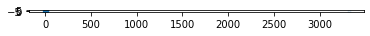

0.894730269908905

In [692]:
plot_eigv((k.T @ q).eig()[0] if qk else (B.T @ A).eig()[0], start_i=0)

In [688]:
m = _m  # q->k, output->input
# m = _m.T  # k->q, input->output
values, indices = m.topk(25, largest=True)

In [689]:
indices_fn = tokenizer.convert_ids_to_tokens
# indices_fn = partial(convert_ids_to_tokens, tokenizer=tokenizer)
# show_topk.indices_fn = tokenizer.convert_ids_to_tokens
# show_topk.indices_fn = partial(convert_ids_to_tokens, tokenizer=tokenizer)
for i in values.abs().mean(1).topk(500).indices.tolist():
    print(indices_fn(i), show_topk(values[i][:6], indices[i][:6], indices_fn=indices_fn))

Ġmembranes {'ĠBog': 117.428, 'ĠErik': 116.658, 'atories': 116.29, 'Ph': 116.084, 'tes': 115.933, 'Ġreson': 113.89}
allows {'Ġhandlers': 117.955, 'ESS': 117.333, 'zer': 115.7, 'Ġmeshes': 114.714, 'Ġadvances': 113.172, 'Ġkil': 113.154}
ĠHay {'Ġfue': 119.729, 'Ġmeshes': 116.437, 'NET': 113.289, 'ĠMoy': 113.228, 'Ġadvances': 112.654, 'tes': 112.538}
robat {'Ġkil': 115.94, 'platform': 114.257, 'Ġmeshes': 112.945, 'ĠDOJ': 112.502, 'ĠGou': 111.675, 'Ġpert': 111.614}
Ġtragic {'Ġtelescopes': 113.723, 'Naz': 113.282, 'Ġhandlers': 113.038, 'tes': 111.536, 'Ġadvances': 110.915, 'outh': 110.892}
ĠLU {'Ġsequels': 117.292, 'ez': 115.518, 'Ġminions': 113.5, 'ĠDynamics': 113.304, 'Ġkil': 111.642, '\\":': 111.642}
ĠRap {'Ġparticle': 115.097, 'Ġadvances': 112.892, 'Naz': 112.545, 'Ġcomplex': 112.513, 'Ġbattery': 111.69, 'gy': 110.97}
users {'tes': 115.359, 'Ġhandlers': 113.985, 'Ġmetals': 112.747, 'Ġtelescopes': 111.755, 'render': 111.208, 'Sea': 110.122}
ĠAgain {'ELS': 111.637, 'Ġlaws': 110.786, 'Ġadvan

In [162]:
i = tokenizer.encode(' nobody')[0]; print(tokenizer.convert_ids_to_tokens(i))
show_topk(*m[i].topk(10))

Ġnobody


{tensor(47808): 20.703,
 tensor(32451): 20.29,
 tensor(12717): 20.169,
 tensor(41151): 20.052,
 tensor(24990): 19.609,
 tensor(26111): 19.299,
 tensor(24527): 19.258,
 tensor(47021): 18.431,
 tensor(29715): 18.342,
 tensor(28257): 18.078}

## Attribution

In [ ]:
for data_tuple in data_tuples:
    text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels = data_tuple[:8]
    print(text)
    with torch.no_grad():
        o = forward(model, inputs, labels=labels, by_head=True)
        # so = sum_forward(model, o, reduce_fn=torch.cat, reshape=True)
    loss, _ = show_predictions(text, examples, tokenizer, o.logits, bos_indices, eos_indices, answers, labels, 
                    topk=3, loss_reduction='mean', show_range=range(k_shot, len(examples)), sep='\t')
    print(loss)
    attn_attr = {}
    del data_tuple[8:]
    data_tuple += [o, attn_attr]


N j R -> j
S u v -> u
o m Z -> m
K b x -> b
j X U -> X
W S l -> S
s l r -> l
r a A -> a

* X 0.39 {' X': 0.39, ' j': 0.228, ' U': 0.085} 	 j X U -> X
* S 0.421 {' S': 0.421, ' l': 0.237, ' W': 0.1} 	 W S l -> S
* l 0.59 {' l': 0.59, ' r': 0.172, ' s': 0.073} 	 s l r -> l
* a 0.449 {' a': 0.449, ' r': 0.235, ' A': 0.188} 	 r a A -> a
tensor(0.7830)

K n p -> n
B l m -> l
n V h -> V
j d T -> d
a s N -> s
B I C -> I
d A o -> A
B C h -> C

* s 0.437 {' s': 0.437, ' N': 0.324, ' a': 0.091} 	 a s N -> s
* I 0.589 {' I': 0.589, ' C': 0.167, ' N': 0.07} 	 B I C -> I
* A 0.692 {' A': 0.692, ' o': 0.158, ' d': 0.046} 	 d A o -> A
* C 0.81 {' C': 0.81, ' h': 0.062, ' B': 0.027} 	 B C h -> C
tensor(0.4842)

g H w -> H
v P l -> P
f W A -> W
j G O -> G
K h e -> h
n b V -> b
W o N -> o
t p c -> p

  h 0.153 {' K': 0.541, ' h': 0.153, ' H': 0.079} 	 K h e -> h
* b 0.586 {' b': 0.586, ' n': 0.159, ' V': 0.117} 	 n b V -> b
  o 0.312 {' N': 0.395, ' o': 0.312, ' O': 0.078} 	 W o N -> o
* p 0.501 {' p':

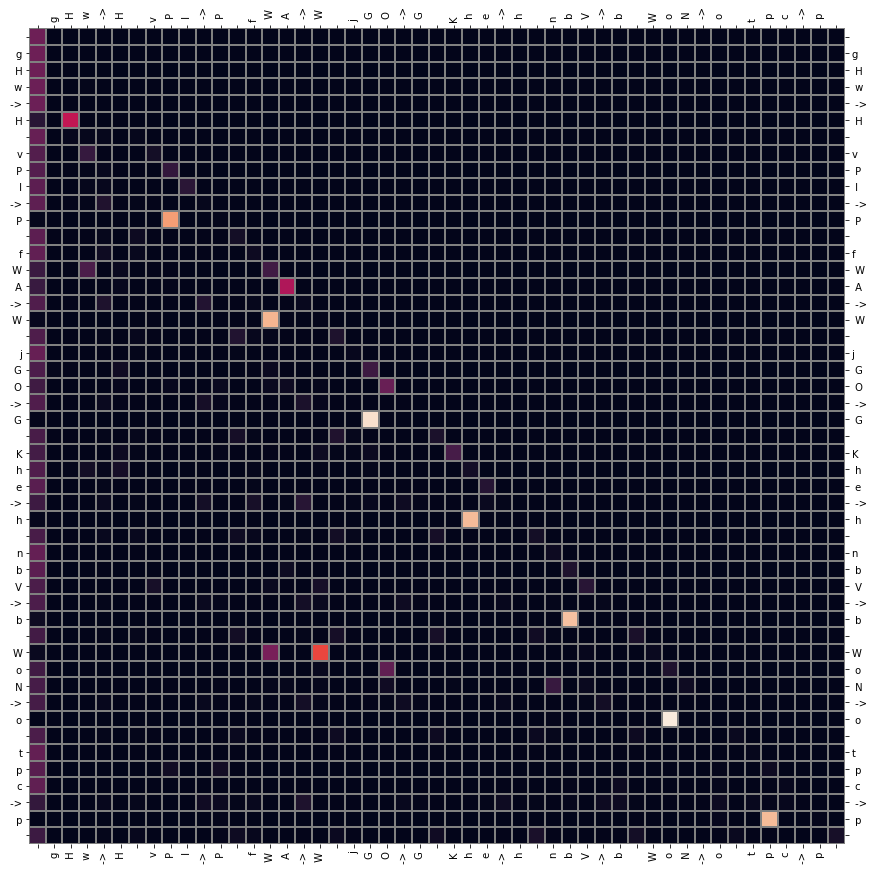

In [980]:
plot_attn(get_argmax_attn_labels(o, 8, 7), tokens)

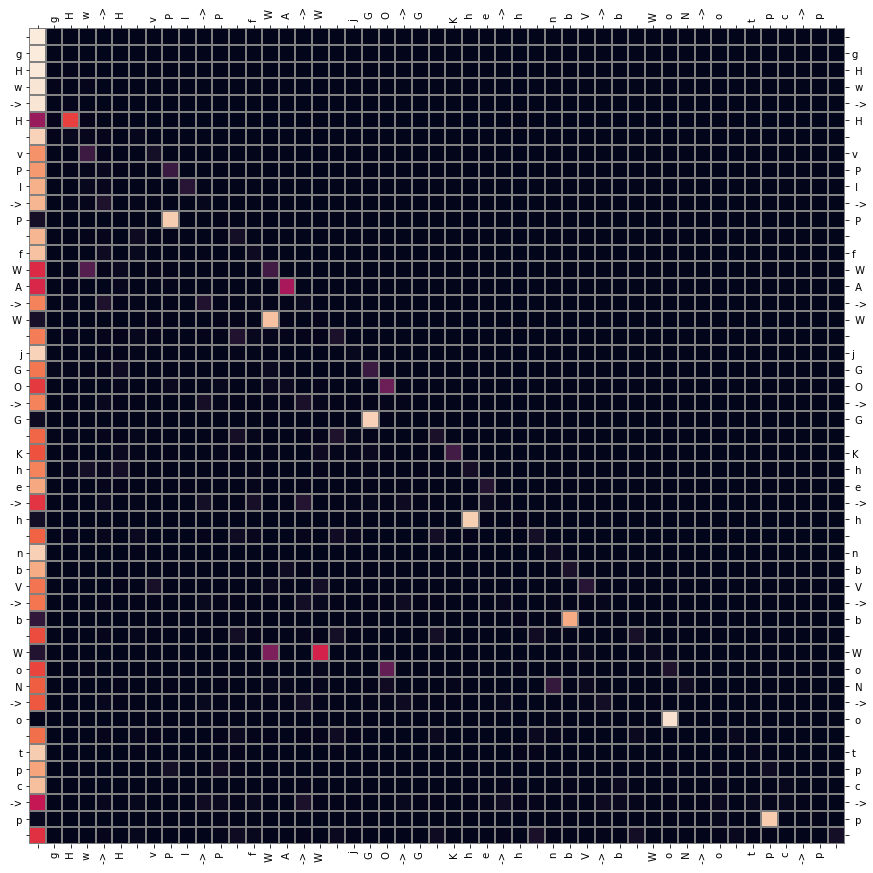

In [979]:
plot_attn(o.attentions[8][0, 7], tokens)

In [900]:
i = -1
root = Node('[-1] root')
root.data = AttrData(step=i)
nodes = {}
nodes[i] = root
print_tree(root)

 [-1] root


In [1026]:
# 查看当前父节点的信息
i = -1
parent = nodes[i]#.parent.children[0]
print(parent.name)
attr = parent.data.attr
if attr is not None:
    list(zip(*topk_md(attr.head, 10)))
    list(zip(*topk_md(attr.mlp, 5)))

[-1] root


In [1027]:
# 选择下一步要归因的head/mlp，创建节点数据
topk = 0
layer, head = 1, 7 #list(zip(*topk_md(attr.head, 10)[:2]))[topk]
# layer, head = np.array(list(zip(*topk_md(attr.head, 10)[:2])))[topk].T
# layer, head = list(zip(*topk_md(attr.mlp, 10)))[topk][0], None
label_type = [None, 'labels', 'argmax_labels', 'argmax_attn_labels', 'attn_labels'][-2]
attribute_k = True
if i == -1: assert label_type is not None # in ['labels', 'argmax_labels', 'argmax_attn_labels', 'attn_labels']
else: label_type = None
data = AttrData(step=i + 1, topk=topk, layer=layer, head=head, label_type=label_type, 
    attribute_k=label_type in ['argmax_attn_labels', 'attn_labels'] and attribute_k)
print(data2str(data))

[0] top0 1-7 argmax_attn_labels attr_k


In [1028]:
# 创建节点添加到树，并作为当前父节点
i += 1
node = Node(data2str(data), parent)
node.data = data
nodes[i] = node
print([dt[0] for dt in data_tuples], k_shot)
nodes[i].name = '*' + nodes[i].name
print_tree(root)
nodes[i].name = nodes[i].name[1:]  # strip prepending '*'

['\nN j R -> j\nS u v -> u\no m Z -> m\nK b x -> b\nj X U -> X\nW S l -> S\ns l r -> l\nr a A -> a\n', '\nK n p -> n\nB l m -> l\nn V h -> V\nj d T -> d\na s N -> s\nB I C -> I\nd A o -> A\nB C h -> C\n', '\ng H w -> H\nv P l -> P\nf W A -> W\nj G O -> G\nK h e -> h\nn b V -> b\nW o N -> o\nt p c -> p\n'] 4
          ┌[0] top0 1-7 argmax_attn_labels
          ├*[0] top0 1-7 argmax_attn_labels attr_k
          ├[0] top0 3-11 argmax_attn_labels┐
          │                                └[1] top0 0
          ├[0] top0 6-2 argmax_attn_labels┐
          │                               └[1] top1 5
          ├[0] top0 6-2 argmax_attn_labels attr_k┐
          │                                      └[1] top1 5
 [-1] root┤
          │                                      ┌[1] top0 2
          ├[0] top0 8-7 argmax_attn_labels attr_k┤
          │                                      └[1] top1 7
          ├[0] top0 3-11 argmax_attn_labels attr_k┐
          │                                       

In [146]:
# 创建节点添加到树，并作为当前父节点
i += 1
node = Node(data2str(data), parent)
node.data = data
nodes[i] = node
print([dt[0] for dt in data_tuples], k_shot)
nodes[i].name = '*' + nodes[i].name
print_tree(root)
nodes[i].name = nodes[i].name[1:]  # strip prepending '*'

['\nN j R -> j\nS u v -> u\no m Z -> m\nK b x -> b\nj X U -> X\nW S l -> S\ns l r -> l\nr a A -> a\n', '\nK n p -> n\nB l m -> l\nn V h -> V\nj d T -> d\na s N -> s\nB I C -> I\nd A o -> A\nB C h -> C\n', '\ng H w -> H\nv P l -> P\nf W A -> W\nj G O -> G\nK h e -> h\nn b V -> b\nW o N -> o\nt p c -> p\n'] 4
          ┌[0] top9 13-2 attn_labels attr_k
 [-1] root┤
          │                         ┌[1] top0 8-1 attn_labels attr_k
          │                         │            ┌[2] top0 6-10 attn_labels attr_k
          │                         ├[1] top0 8-1┤
          │                         │            └[2] top0 6-10┐
          │                         │                          └[3] top0 5-1┐
          │                         │                                       └[4] top0 4┐
          │                         │                                                  └[5] top0 2
          └[0] top9 13-2 attn_labels┤
                                    │                          

attribute ... done 0:00:01.413620
attribute2 ... done 0:00:00.272591


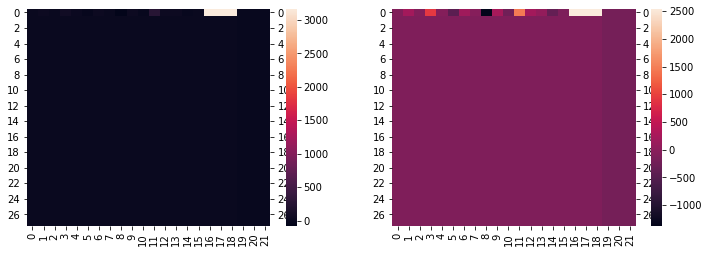

attribute ... done 0:00:01.343355
attribute2 ... done 0:00:00.343793


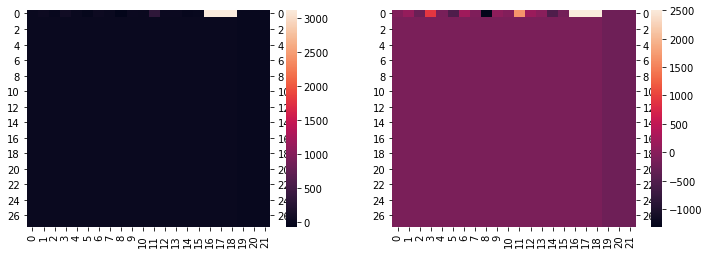

attribute ... done 0:00:01.361169
attribute2 ... done 0:00:00.319417


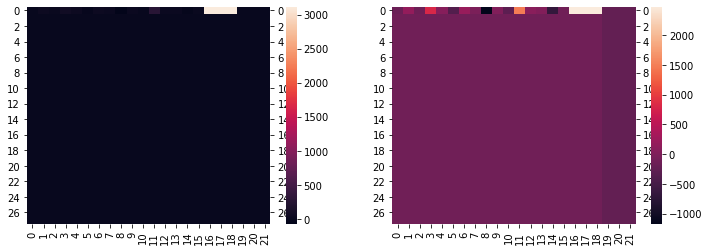

attribution step 0 results


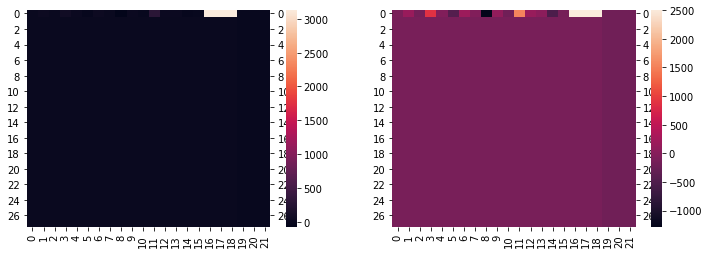

,0,1,2,0,1,2,0,1,0,1
0,0,11,281.465088,0,11,1531.825073,0,3135.177002,0,2511.611328


In [1029]:
attrs, attrs2 = [], []
for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:]:
    fns = []; node = nodes[i]
    while node!=root: fns.append(node2fn(model,node,o,labels,attn_attr)); node=node.parent if not node.data.label_type else root

    (output_layer, _labels) = (nodes[i].data.layer, None) if len(fns) > 0 else (L, labels)
    to_layer = max(output_layer) if isinstance(output_layer, Iterable) else output_layer
    keys = ['attn_weights', 'mlp_mask', 'embed_mask'] # 'attn_weights' or 'neuron_mask'
    x = OrderedDict((key, get_x(key, o, to_layer=to_layer)) for key in keys)
    fwd_fn = partial(sum_forward, outputs=o, labels=_labels, output_layer=output_layer)
    with Timer('attribute'): attr, ys, logits = attribute(fwd_fn, model, x, fns, num_points=4 if attribute_k else 8)

    fwd_fn = partial(sum_forward, outputs=o, labels=_labels, reduce_fn=torch.cat, scaled=False)
    with Timer('attribute2'): attr2 = attribute2(fwd_fn, model, x, fns)

    plot_attr(attr, attr2)
    # pd.concat([to_df(*topk_md(a[: to_layer], 10)) for a in [attr.head, attr2.head, attr.mlp, attr2.mlp]], axis=1)
    attrs.append(attr); attrs2.append(attr2)
    attn_attr[nodes[i].name] = attr.attn # associate non-averageable attn attr to current node in this tricky way
        
print(f'attribution step {i} results')
attr, attr2 = reduce_objects(attrs, ['head', 'neuron', 'mlp']), reduce_objects(attrs2, ['head', 'mlp'])
plot_attr(attr, attr2)
pd.concat([to_df(*topk_md(a[: to_layer], min(to_layer, 10))) for a in [attr.head, attr2.head, attr.mlp, attr2.mlp]], axis=1)
nodes[i].data.attr = attr

In [ ]:
for l, h, v in zip(*topk_md(attr.head, 5)):
    print('%d-%d %.3f K-composition = %.3f eigenvalue_positivity =' % 
        (l, h, get_conductivity(eigv_positivity012, l, h, plot=True, figsize=(2, 1)),
        k_comp_max[l, h].item()), eigv_positivity[l, h])

1 10 2942.3008 None tensor([ 0.4636, -0.0008]) tensor(0.3439) tensor(0.0025)
tensor([ -90.0477,  684.6472, 1485.3276], grad_fn=<CatBackward>)


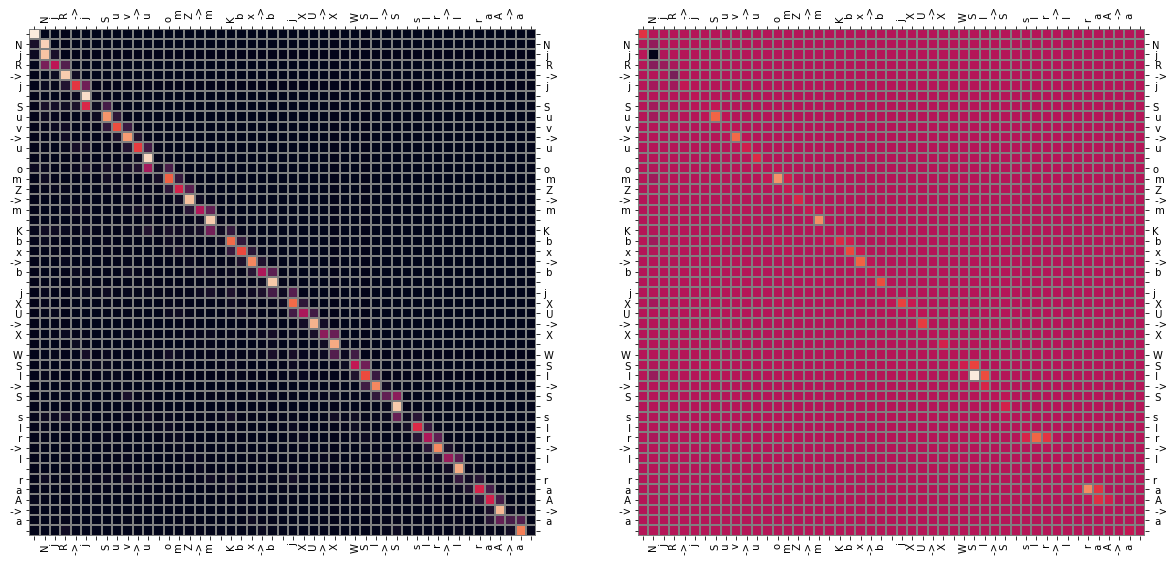

tensor([ -96.0853,  719.5251, 1546.8931], grad_fn=<CatBackward>)


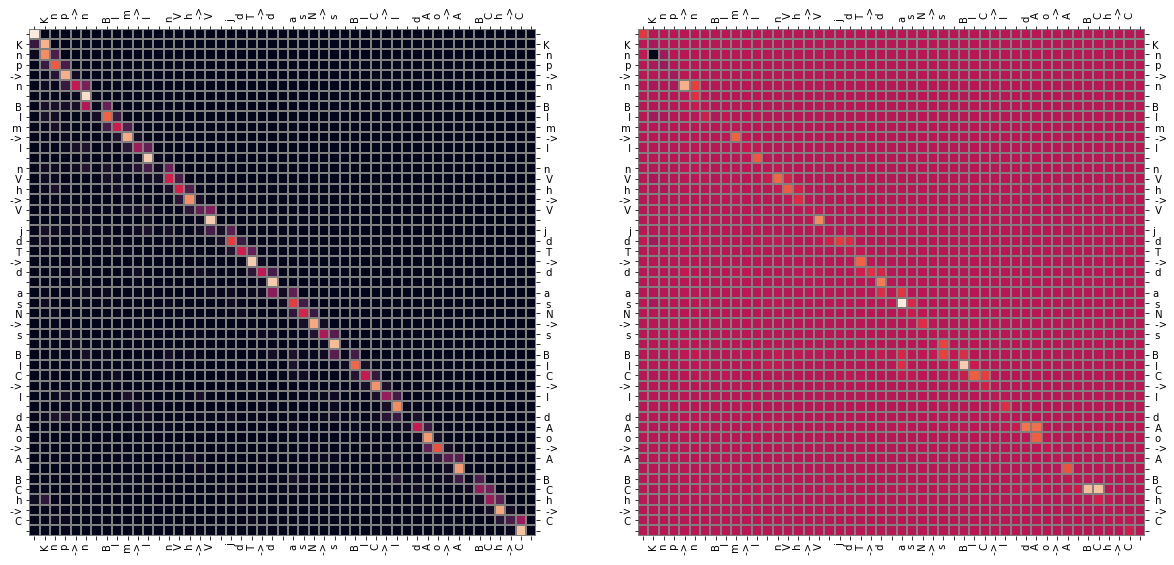

tensor([ -74.5121,  674.6307, 1425.7327], grad_fn=<CatBackward>)


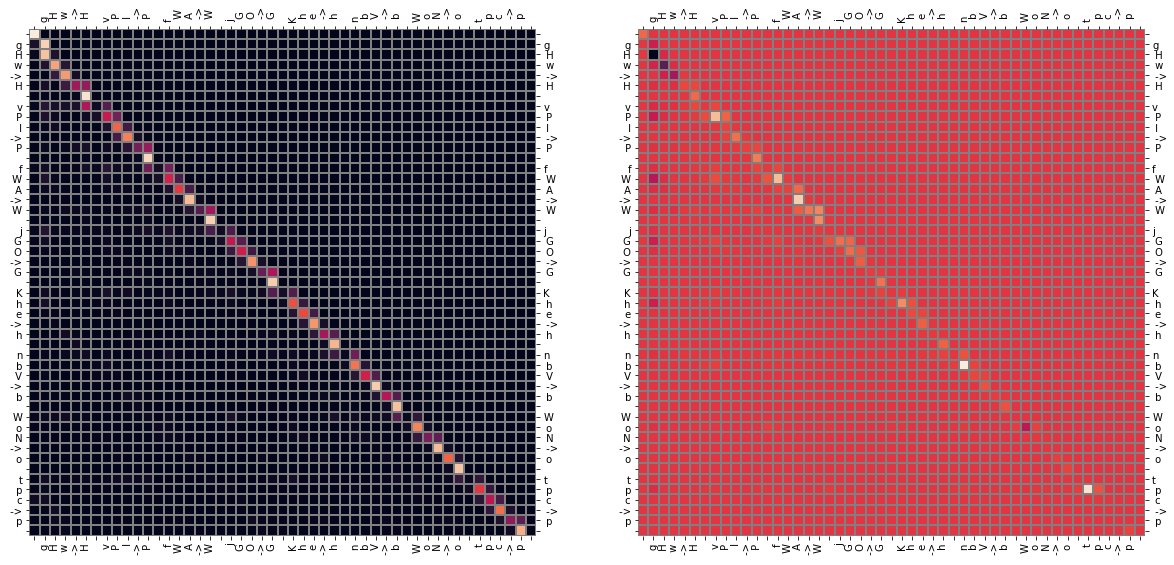

0 3 1868.7975 0 tensor([ 0.1005, -0.1278]) tensor(0.1317) tensor(0.)
tensor([ 286.3988,  982.8146, 1677.5736], grad_fn=<CatBackward>)


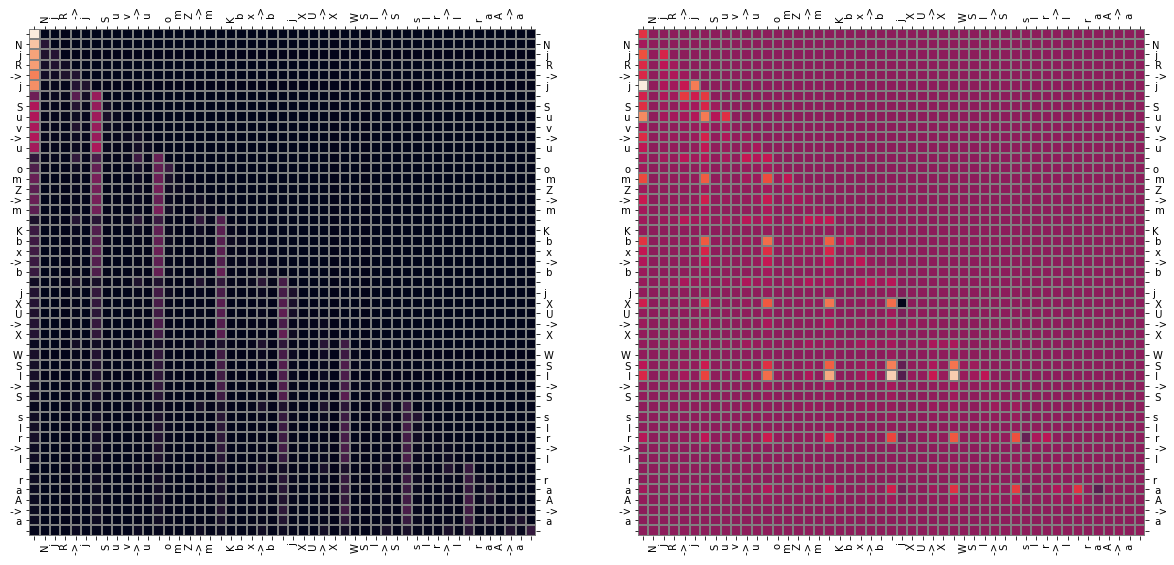

tensor([ 312.0621, 1065.2679, 1816.5359], grad_fn=<CatBackward>)


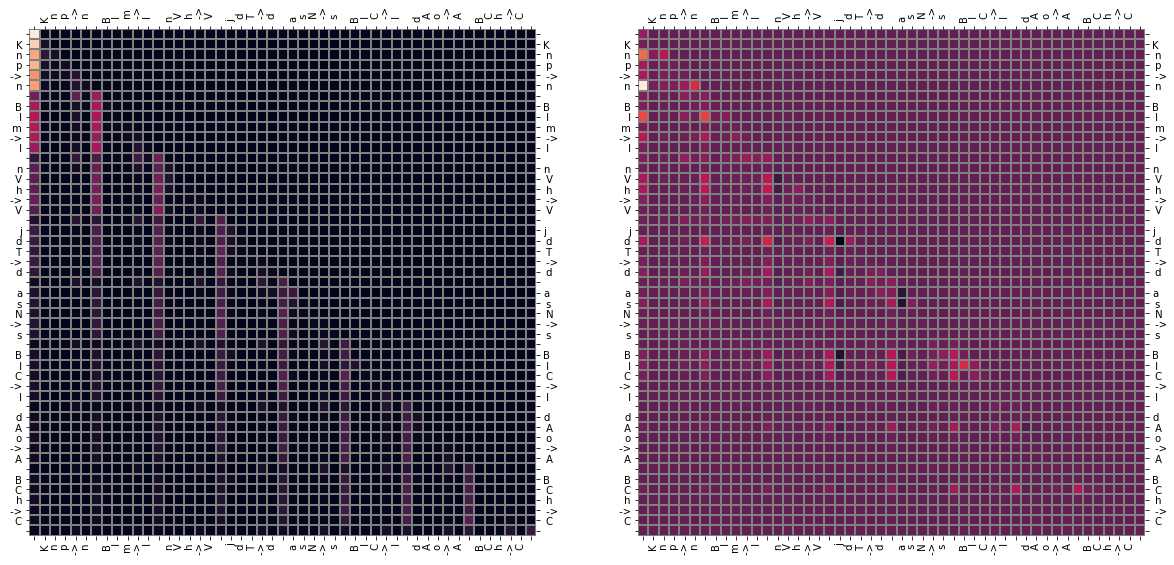

tensor([ 318.1690, 1000.4028, 1681.0576], grad_fn=<CatBackward>)


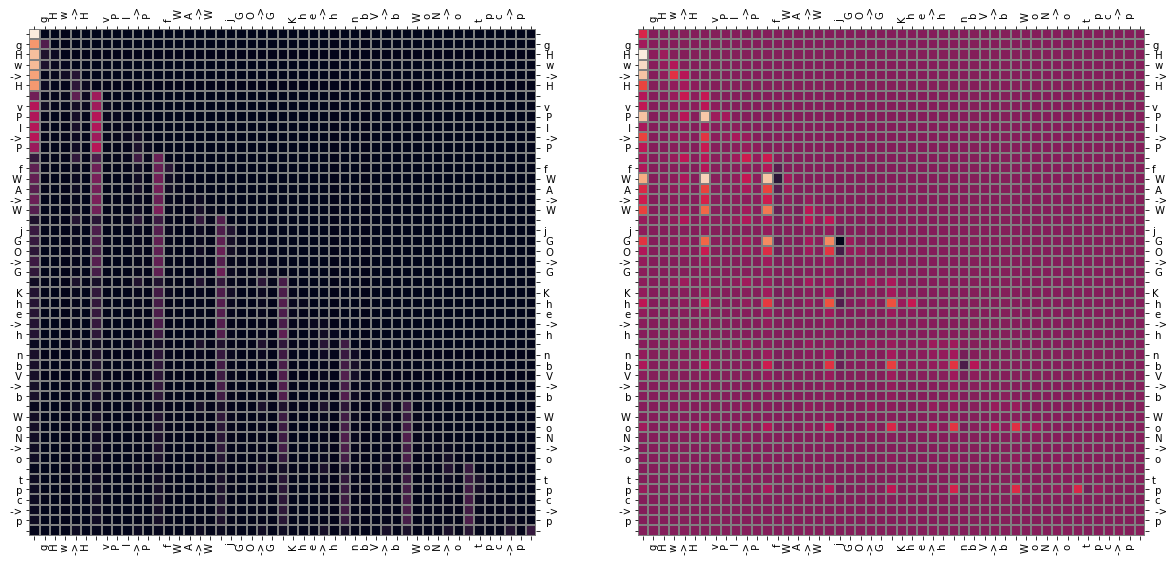

In [1016]:
# attr = nodes[i].data.attr
for l, h, v in zip(*topk_md(attr.head, 2)):
# for l, h in [(16, 6), (14, 6), (13, 2)]:
    print(l, h, v, get_head_rank(attr2.head, l, h), eigv_positivity[l, h], pos_score[l, h], k_comp_wmean[l, h])
    for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[:]:
        fns = []; node = nodes[i]
        while node != root:
            fns.append(node2fn(model, node, o, labels, attn_attr))
            node = node.parent if not node.data.label_type else root
        
        x = OrderedDict((key, get_x(key, o, to_layer=l)) for key in keys)
        fwd_fn = partial(sum_forward, outputs=o)
        fn = partial(head_forward, layer=l, head=h, attn_weights=o.attentions[l],
                            labels=labels if len(fns) == 0 else None)
        # fn = partial(mlp_forward, layer=l, labels=labels)
        post_fwd_fn = compose_forward_fns([fn] + fns, scaled=True)
        _, ys, logits = attribute(fwd_fn, model, x, post_fwd_fn, num_points=3); print(ys)
        if isinstance(logits, torch.Tensor) and logits.size(-1) == model.lm_head.out_features:
            _ = show_predictions(text, examples, tokenizer, logits[-1:], bos_indices, eos_indices, answers, labels, 
                topk=4, show_range=range(k_shot, len(examples)), sep='\t')

        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))
        aa = attn_attr[nodes[i].name][l, h]
        # attn_labels = aa / (aa.sum(-1, keepdim=True) + 1e-9)  # ij->i1
        for ax, a in zip(axs, [o.attentions[l][0, h], aa, ]): plot_attn(a, tokens, ax=ax)
        plt.show()

In [ ]:
group0 = [(1, 7), (6, 2), (8, 7)]; group1 = [(3, 6), (3, 11), (4, 8), (6, 10)]
neuron = attr.neuron
for (l0, h0), (l1, h1) in product(group0, group1):
    print(f'{l0}-{h0}, {l1}-{h1}', nn.CosineSimilarity(0)(neuron[l0, h0].mean(0), neuron[l1, h1].mean(0)))
print()
for (l0, h0), (l1, h1) in combinations(group0, 2):
    print(f'{l0}-{h0}, {l1}-{h1}', nn.CosineSimilarity(0)(neuron[l0, h0].mean(0), neuron[l1, h1].mean(0)))
print()
for (l0, h0), (l1, h1) in combinations(group1, 2):
    print(f'{l0}-{h0}, {l1}-{h1}', nn.CosineSimilarity(0)(neuron[l0, h0].mean(0), neuron[l1, h1].mean(0)))

13 9 1.38291 0
tensor([ -9.0720,  -6.7210, -12.1230], grad_fn=<CatBackward>)
  June 0.0 {'May': 0.966, 'June': 0.029, ' May': 0.005, ' June': 0.0} 	 July -> June
  Thursday 0.05 {'Thursday': 0.95, ' Thursday': 0.05, 'Wednesday': 0.0, ' Wednesday': 0.0} 	 Friday -> Thursday
  J 0.0 {'K': 0.228, 'J': 0.222, 'H': 0.126, 'E': 0.094} 	 K -> J
  second 0.0 {'two': 0.999, 'second': 0.001, ' Two': 0.0, '2': 0.0} 	 third -> second
  September 0.072 {' Sept': 0.323, 'September': 0.144, 'August': 0.084, '09': 0.083} 	 October -> September
  V 0.0 {'G': 0.233, 'J': 0.205, 'H': 0.102, 'M': 0.085} 	 W -> V
  6 0.0 {'6': 0.939, '5': 0.06, '4': 0.002, ' 6': 0.0} 	 7 -> 6
  4 0.0 {'4': 1.0, ' 4': 0.0, '3': 0.0, '5': 0.0} 	 5 -> 4
  seventh 0.0 {'seven': 0.984, 'six': 0.01, '7': 0.002, 'five': 0.001} 	 eighth -> seventh
  1 0.0 {'1': 0.977, '2': 0.023, ' 1': 0.0, '0': 0.0} 	 2 -> 1


(tensor(0.4255, grad_fn=<NllLossBackward>), False)

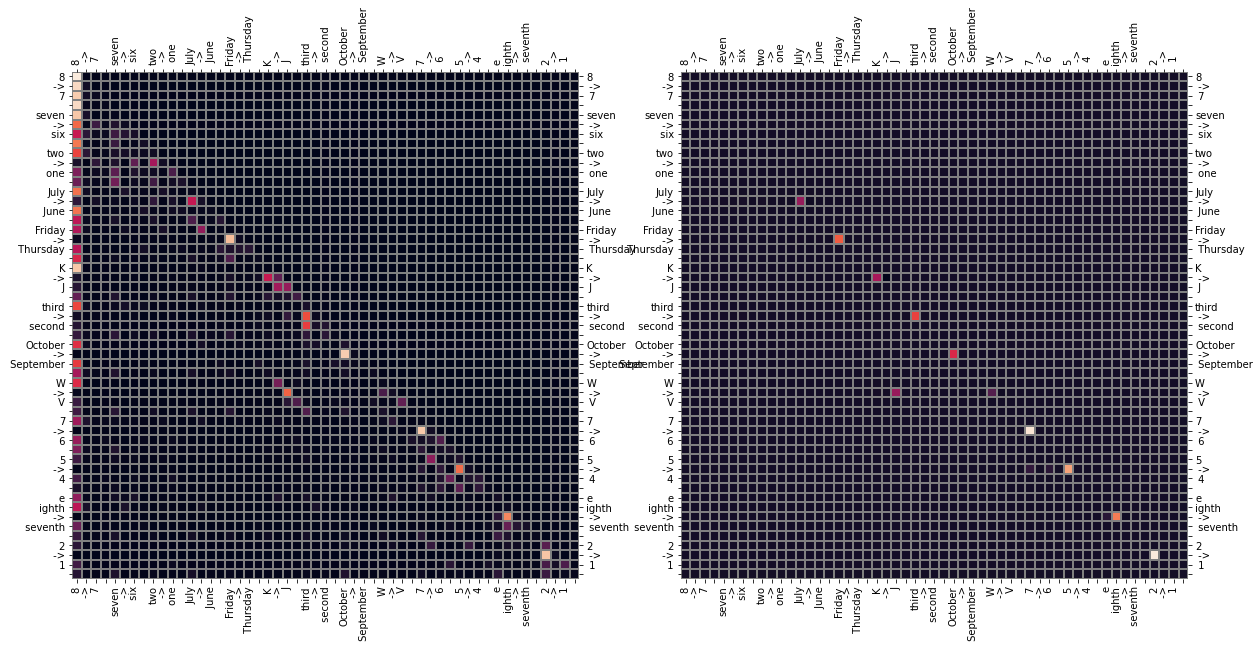

In [268]:
attr = nodes[i].data.attr
for l, h, v in zip(*topk_md(attr.head, 1)):
    # if l != 14: continue
    print(l, h, v, get_head_rank(attr2.head, l, h))
    for text, examples, inputs, tokens, bos_indices, eos_indices, answers, labels, o, attn_attr in data_tuples[1:2]:
        x = OrderedDict((key, get_x(key, o, to_layer=l)) for key in keys)
        fwd_fn = partial(sum_forward, outputs=o)
        fn = partial(head_forward, layer=l, head=h, attn_weights=o.attentions[l],
                            labels=labels if len(fns) == 0 else None)
        post_fwd_fn = compose_forward_fns([fn] + fns, scaled=True)
        _, ys, logits = attribute(fwd_fn, model, x, post_fwd_fn, num_points=3, batch_size=3); print(ys)
        if logits.size(-1) == model.lm_head.out_features:
            show_predictions(text, examples, tokenizer, logits[-1:], bos_indices, eos_indices, answers, labels, 
                topk=4, show_range=range(k_shot, len(examples)), sep='\t')

        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(20, 10))
        aa = attn_attr[nodes[i].name][l, h]
        # attn_labels = aa / (aa.sum(-1, keepdim=True) + 1e-9)  # ij->i1
        for ax, a in zip(axs, [o.attentions[l][0, h], aa, ]):
            plot_attn(a, tokens, ax=ax)
        plt.show()

In [ ]:
# 对某层的attn_weights单独梯度归因
attrs = []
for attribute_layer in range(27):
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'head_mask': torch.ones(1, H, o.hidden_states[0].size(1))}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y, num_points=8)
    ys
    attrs.append(attr)
    
head_attr2 = rearrange([attr['head_mask'] for attr in attrs], 'l n i -> l n i')
head_attr2 = torch.einsum('lni->ln', head_attr2)
list(zip(*topk_md(head_attr2, 10)))

# 对某层的attn_weights单独梯度归因
for attribute_layer, attribute_head, __ in list(zip(*topk_md(head_attr, 10)))[:3]: # heads 27-17, 17-4, 22-13
    forward_fn = partial(forward, inputs=inputs, labels=labels, loss_reduction='per_example_mean', attribute_layer=attribute_layer)
    x = {'attn_weights': o.attentions[attribute_layer]}
    def get_y(outputs): return -outputs.loss
    attr, ys = attribute(forward_fn, x, get_y)
    # ys
    print(attribute_layer, attribute_head)
    plot_attn(attr['attn_weights'][attribute_head], tokens, figsize=(5, 5))
    plt.show()

以上用归因找到对最终预测结果起重要作用的上层heads（induction heads），  
以下用归因找到对上层induction heads的attn_weights起重要作用的下层heads（Q-compostion or K-composition with induction heads）

In [72]:
# 找第2重要的induction head（17-4）的K-composition heads
layer, head, _ = list(zip(*topk_md(head_attr, 10)))[1]
layer, head
aw_label = binarize(attn_attr[layer, head])
wq, wk = get_head_weights(layer, head)[:2]

(17, 4)

In [73]:
# 对head_output归因
query = torch.einsum('bie,de->bid', o.hidden_states[layer], wq)
head_outputs = rearrange(list(o.head_outputs), 'l 1 n i e -> 1 l n i e')[:, :layer]
key = torch.einsum('blnje,de->blnjd', head_outputs, wk)
attn_logits = torch.einsum('bid,blnjd->lnij', query, key) # b==1
# i j l n -> n_label l n -> ln
attn_head_attr = rearrange(attn_logits, 'l n i j -> i j l n')[aw_label == 1].mean(0)

In [ ]:
_ = sns.heatmap(attn_head_attr)
list(zip(*topk_md(attn_head_attr, 10)))

In [80]:
# 对attn_weights归因
# h2: a higher-layer (induction) head (layer, head)
# h1: lower-layer heads forming K-composition with h2
# i: h2 query position, j: h2 key position, k: h1 query position
head_inputs_ = rearrange(list(o.head_inputs), 'l 1 n j e -> l n j e')[:layer]
attentions_ = attentions[:layer]
if True: # faster version
    key = head_inputs_ @ wk.T  # lnje,de->lnjd
    lnkj_attn_logits = torch.einsum('bkd,lnjd->lnkj', query, key) # b==1
    lnkij_attn_logits = torch.einsum('lnij,lnkj->lnkij', attentions_, j_attn_logits)
else: # slower version, but easier to understand (similar to unseal)
    lnije = torch.einsum('lnij,lnje->lnije', attentions_[:layer], head_inputs_)
    key = lnije @ wk.T  # lnije,de->lnijd    
    lnkij_attn_logits = torch.einsum('bkd,lnijd->lnkij', query, key)  # b==1
# kij means k attends i in higher layer, i attends j in lower layer
attn_attn_attr = torch.einsum('lnkij,ki->lnij', lnkij_attn_logits, aw_label)

In [ ]:
for l, h, v in zip(*topk_md(attn_head_attr, 10)):
    print(l, h, v)
    fig, axs = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15, 5))
    for ax, a in zip(axs, [attentions[l, h], attn_attn_attr[l, h], binarize(attn_attn_attr[l, h])]):
        plot_attn(a, tokens, ax=ax)
    plt.show()

## Tune intermediary heads

In [ ]:
d = defaultdict(int)
pairs = []
for l0, h0, l2, h2 in zip(*np.unravel_index(affinities.view(-1).topk(500).indices, affinities.size())):
    if d[(l0, h0)] < 10:
        d[(l0, h0)] += 1
        pairs.append(((l0, h0), (l2, h2)))
        if len(pairs) == 100: break
Counter([(l0, h0) for (l0, h0), (l2, h2) in pairs]).most_common()
random.shuffle(pairs)
train_set, val_set = pairs[:-20], pairs[-20:]

In [ ]:
def w_forward(head_pairs, wv1, wo1, alpha=0.1, compute_eigv=False):
    wvs0, wos0, wqs2, wks2 = zip(*[get_head_weights(model, l0, h0, transpose=True)[2:] +
                                get_head_weights(model, l2, h2, transpose=True)[:2] 
                                for (l0, h0), (l2, h2) in head_pairs])
    wvs0, wos0 = rearrange(list(wvs0), 'b e d -> b e d'), rearrange(list(wos0), 'b d e -> b d e')
    wqs2, wks2 = rearrange(list(wqs2), 'b e d -> b e d'), rearrange(list(wks2), 'b e d -> b e d')
    wvs0, wos0, wqs2, wks2 = wvs0.to(device), wos0.to(device), wqs2.to(device), wks2.to(device)
    wvo1 = wv1 @ wo1
    q, kT = wvs0 @ wos0 @ wvo1 @ wqs2, wks2.transpose(-2, -1)
    comp_norm = (q @ kT).norm(dim=(-2, -1)).mean()
    # loss = -comp_norm / wvo1.norm()
    loss = -(comp_norm - alpha * wvo1.norm())
    eigvs = [plot_eigv(m.eig()[0], plot=False) for m in kT @ q] if compute_eigv else None
    return loss, comp_norm, eigvs
    
def eval(dataset, wv1, wo1, bsz=8, compute_eigv=False, e=None, wu=None):
    losses, eigvs, comp_norms = [], [], []
    for i in range(len(dataset) // bsz):
        loss, comp_norm, _eigvs = w_forward(dataset[i * bsz: (i + 1) * bsz], wv1, wo1, compute_eigv=compute_eigv)
        losses.append(loss.item())
        comp_norms.append(comp_norm.item())
        if compute_eigv: eigvs += _eigvs
    if compute_eigv:
        print(torch.Tensor(eigvs))
        # e = model.transformer.h[l1].ln_1(_e)
        A, B = wu @ wo1.T.to('cpu'), e @ wv1.to('cpu')
        print('wvo1 eigv_pos =', plot_eigv((B.T @ A).eig()[0], plot=False))
    return round(sum(losses) / len(losses), 4), round(sum(comp_norms) / len(comp_norms), 4), round((wv1 @ wo1).norm().item(), 4)

In [ ]:
device = 'cuda'
wv1, wo1 = get_head_weights(model, l1, h1, transpose=True)[2:]
wv1, wo1 = wv1.detach().clone(), wo1.detach().clone()
wv1, wo1 = wv1.to(device), wo1.to(device)
_ = wv1.requires_grad_(True); _ = wo1.requires_grad_(True)
optimizer = optim.AdamW([wv1, wo1], lr=1e-4)
bsz, eval_bsz = 8, 4
# test(model, data_tuples)
# test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=wo1.to('cpu'))
# test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=2*wo1.to('cpu'))
with torch.no_grad(): print('Epoch', -1, 'train', eval(train_set, wv1, wo1), 
                        'val', eval(val_set, wv1, wo1, bsz=eval_bsz, compute_eigv=True, e=e, wu=wu))
for epoch in range(2):
    random.shuffle(train_set)
    for i in tqdm(range(len(train_set) // bsz)):
        optimizer.zero_grad()
        loss = w_forward(train_set[i * bsz: (i + 1) * bsz], wv1, wo1)[0]
        loss.backward()
        optimizer.step()
    with torch.no_grad(): print('Epoch', epoch, 'train', eval(train_set, wv1, wo1), 
                            'val', eval(val_set, wv1, wo1, bsz=eval_bsz, compute_eigv=True, e=e, wu=wu),)
                            # test(model, data_tuples, replaced_head=(l1, h1), wv=wv1.to('cpu'), wo=wo1.to('cpu')))

In [473]:
all_attrs, all_yss = {}, {}

In [324]:
def qk_forward(model, outputs, layer, head, aw_label, attr_x, **mask_kwarges):
    ln = blocks[layer].ln_1
    kwargs = {x: ln(outputs.hidden_states[layer]) for x in ['hq', 'hk', 'hv']}
    kwargs[attr_x] = scaled_ln(ln, sum_forward(model, outputs, **mask_kwarges).hidden_states[0], scale=0.01) # attr_x in ['hq', 'hk']
    aw = attn_forward(blocks[layer], **kwargs)[1][:, head]
    aw_label_sum = torch.einsum('ij->', aw_label)
    # print('aw_label_sum =', aw_label_sum)
    mean_prob = torch.einsum('bij,ij->b', aw, aw_label) / aw_label_sum
    mean_logprob = torch.einsum('bij,ij->b', (aw + 1e-8).log(), aw_label) / aw_label_sum
    print('mean_prob =', mean_prob)
    print('mean_logprob =', mean_logprob)
    return mean_prob, mean_logprob

In [ ]:
# ig attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y)
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
attrs, yss = all_attrs[key], all_yss[key]

In [ ]:
dlosses = [(ys[0] - ys[-1]).item() for ys in yss]
np.array(dlosses)
_ = plt.bar(range(len(dlosses)), dlosses, 0.3)

In [248]:
# nattrs = [attr / abs(dloss) for attr, dloss in zip(attrs, dlosses)]
nattrs = [attr / attr.abs().mean() for attr in attrs]

In [251]:
mean_nattrs = torch.cat([nattr.mean(dim=-1) for nattr in nattrs])

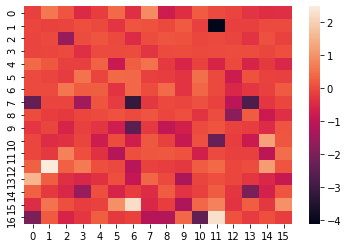

In [252]:
_ = sns.heatmap(mean_nattrs, cbar=True)

In [ ]:
l, h = 6, 6
# attn = o.attentions[l][0, h]
attn = attrs[l][0, h]
plot_attn(attn, tokens)

QK circuit: $W_E^T W_Q^T W_K W_E$  
OV circuit: $W_U W_O W_V W_E$

In [230]:
def plot_eigenvalues(evs, ncols=4):
    fig, axs = plt.subplots(H // ncols, ncols, sharex=True, sharey=True, figsize=(20, 5))
    for i, (e, v) in enumerate(evs):
        e = e.detach().numpy()
        _ = axs[i // ncols][i % ncols].plot(e[:,0], e[:,1], '.')

In [281]:
WQK, WOV = [], []
for l in tqdm(range(L)):
    WQK.append([combine_weights(get_head_weights(l, h), qk=True) for h in range(H)])
    WOV.append([combine_weights(get_head_weights(l, h), qk=False) for h in range(H)])

100%|██████████| 24/24 [00:05<00:00,  4.48it/s]


In [284]:
WQK = [[combine_weights(get_head_weights(l, h), qk=True) for h in range(H)] for l in tqdm(range(L))]
WOV = [[combine_weights(get_head_weights(l, h), qk=False) for h in range(H)] for l in tqdm(range(L))]

100%|██████████| 24/24 [00:01<00:00, 20.26it/s]


In [333]:
# rwqk2, rwov1 = torch.rand(hidden_size, hidden_size) * 10, torch.rand(hidden_size, hidden_size) * 100

# rwq, rwk = torch.rand(hidden_size // H, hidden_size)*10, torch.rand(hidden_size // H, hidden_size)
# rwo, rwv = torch.rand(hidden_size, hidden_size // H), torch.rand(hidden_size // H, hidden_size)*100
# rwqk2, rwov1 = rwq.t().mm(rwk), rwo.mm(rwv)

# rwqk2.mm(rwov1).norm() / (rwqk2.norm() * rwov1.norm())

K-composition: $\text{Id} \otimes A^{h_{-1}} \otimes (W_E^T W_{QK}^h W_{OV}^{h_{-1}} W_E)$, measured by Frobenius norm ratio: $||W_{QK}^{h_2}W_{OV}^{h_1}||_F \mathbin{/} (||W_{QK}^{h_2}||_F ||W_{OV}^{h_1}||_F)$

In [345]:
dl = 3
kcomp3 = np.array([[[(WQK[l][h2].mm(WOV[l-dl][h1]).norm() / (WQK[l][h2].norm() * WOV[l-dl][h1].norm())).item() 
          for h1 in range(H)] for h2 in range(H)] for l in tqdm(range(dl, L))])

100%|██████████| 21/21 [01:23<00:00,  3.96s/it]


In [1703]:
def scatter_plot(a): a = a.detach().numpy(); plt.plot(a[:,0], a[:,1], '.')

In [74]:
chains = [
    [(4, 14), (3, 3)],  # 0.24024388
    [(5, 4), (2, 2)],  # 0.21996385
    [(5, 4), (3, 7)],  # 0.31488344
    [(6, 6), (3, 3)],  # 0.27304175
    [(6, 6), (5, 3)],  # 0.12567882
]

In [314]:
(l2, h2), (l1, h1) = chains[4]

In [433]:
e = WQK[l2][h2].mm(WOV[l1][h1]).eig()[0]

In [435]:
e[:10] = 0

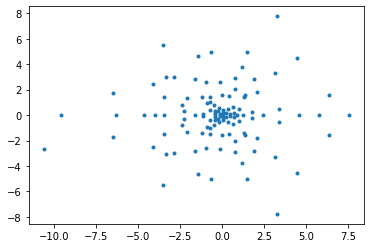

In [436]:
scatter_plot(e)

In [437]:
e = WOV[l2][h2].eig()[0]

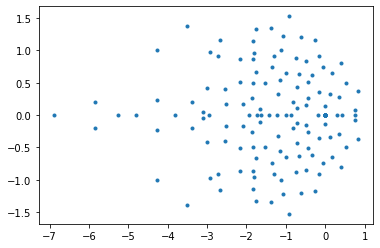

In [438]:
scatter_plot(e)

In [356]:
a = kcomp3[2]; ind = np.unravel_index(a.argmax(), a.shape); ind, a[ind]

((4, 2), 0.21996384859085083)

<AxesSubplot:>

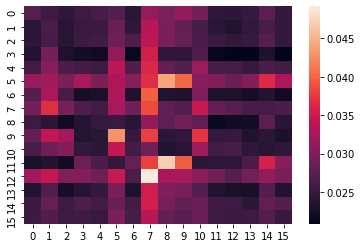

In [319]:
kcomp = np.array(kcomp)
sns.heatmap(kcomp, cbar=True)

In [364]:
wov_evs = [torch.eig(combine_weights(get_head_weights(3, h), qk=False, with_embedding=True, BA=True)) for h in tqdm(range(H))]

100%|██████████| 16/16 [00:02<00:00,  7.17it/s]


  0%|          | 0/16 [3:32:06<?, ?it/s]


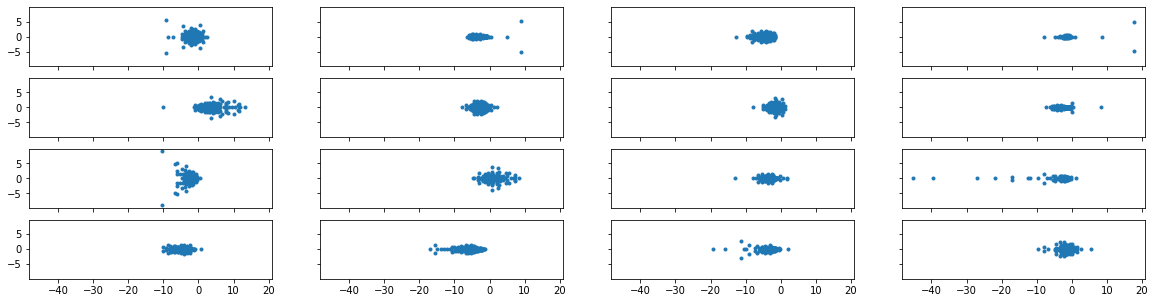

In [363]:
plot_eigenvalues(wov_evs)

In [138]:
w_eu = w_e.matmul(w_u)

In [522]:
def mlp(layer): return lambda x: blocks[layer].mlp(blocks[layer].ln_2(x))
def mlp0(layer): return lambda x: blocks[layer].mlp(x)

In [186]:
def attn(layer): return lambda x: blocks[layer].attn(blocks[layer].ln_1(x))

In [537]:
w_e2 = w_e * 50
w_eu2 = (w_e2 + mlp0(L-1)(w_e2)).matmul(w_u)

In [ ]:
# grad attribution
pred_attn = False
keys = ['aw'] #  'attn_out', 'head_out', 'attn_output', 'ffn_output'
keys2 = [] #['head_output', 'attn_output']
layer_range = (0, layer1) if pred_attn else (0, layer_out)
attrs, grads = defaultdict(list), defaultdict(list)
num_points, batch_size = 5, 5
    
for i in tqdm(range(*layer_range)):
    am = get_attn_module(blocks[i])
    scaled_emb, step, grad = {}, {}, {}
    embs = [getattr(o, keys[0])[i]]
    if len(embs) == 1 and keys[0] != 'aw': all_embs[task_name][keys[0]] = embs[0][0]
        
    for key, emb in zip(keys, embs):
        scaled_emb[key], step[key] = scaled_input(emb, num_points)
        _ = scaled_emb[key].requires_grad_(True)
        grad[key] = None
    if i == layer0: ys = []
    for j in range(0, num_points, batch_size):
        sliced_scaled_emb = [scaled_emb[key][j: j + batch_size] for key in keys]
#         for key in keys2: setattr(am if key in ['head_output'] else blocks[i], key, None)
        outputs = forward(am, keys, values=sliced_scaled_emb, exit_module=blocks[layer1+1] if pred_attn else None)
        y = globalize(outputs.attentions[layer2])[:, head2, src, tgt] if pred_attn else outputs.logits.softmax(-1)[:, src, pred_label]
#         h1 = ln1(outputs.hidden_states[12])
#         y = tgt_attn_loss(h1, _attn1, key0, residual=None, temperature=20)
        if i == layer0: ys.append(y);
#         if keys2:
#             sliced_scaled_emb2 = [getdelattr(am if key in ['head_output'] else blocks[i], key) for key in keys2]
#             sliced_scaled_emb += sliced_scaled_emb2
#             if j == num_points - batch_size: step.update({key: emb[-1:]/num_points for key, emb in zip(keys2, sliced_scaled_emb2)})
        sliced_grads = torch.autograd.grad(y.flatten().unbind(), sliced_scaled_emb)
        for gi, key in enumerate(keys + keys2):
            sliced_grad = sliced_grads[gi].sum(dim=0, keepdim=True)
            grad[key] = sliced_grad if key not in grad or grad[key] is None else grad[key] + sliced_grad
    for key in keys + keys2:
        attr = grad[key] * step[key]
        attrs[key].append(attr.data)
        grads[key].append(grad[key].data)

if len(keys) == 1:
    key = keys[0]
    all_attrs[task_name][key + str(int(pred_attn))] = torch.cat([globalize(a) for a in attrs[key]]) \
        if key == 'aw' else attrs[key][0][0]
#     for key in keys2: attrs[key] = torch.cat(attrs[key])

In [ ]:
plot_attn(globalize(attentions[8])[0, 2], figsize=(20, 20))

In [5395]:
for i, token in enumerate(tokens):
    if token in ['Ċ', '^']: print()
    else: print('%2d %s' %(i, token), end='  ')
tgt_positions


 1 E   2 N   3 K   4 R   5 ->   6 N  
 8 A   9 T  10 D  11 7  12 ->  13 T  
15 Q  16 A  17 P  18 K  19 ->  20 A  
22 A  23 N  24 L  25 5  26 ->  27 N  
29 V  30 1  31 P  32 B  33 ->  34 1  
36 G  37 V  38 7  39 4  40 ->  41 V  
43 R  44 Y  45 J  46 P  47 ->  48 Y  
50 A  51 C  52 S  53 Y  54 ->  55 C  


tensor([ 2,  9, 16, 23, 30, 37, 44, 51])

In [5409]:
a = all_attrs[task_name]['aw' + str(int(pred_attn))]
a = a / a.view(a.size(0), -1).norm(dim=1)[:, None, None, None] #.view(a.size(0), 1, 1, 1)
if not pred_attn:
    src_indices, tgt_indices = [src], [tgt]
    _a = a[:, :, src_indices, tgt_indices]
    values, indices = _a.view(_a.size(0), H, -1).topk(1, dim=-1)
    show_top_heads(values, indices, src_indices=src_indices, tgt_indices=tgt_indices)
    print()
# src_indices = numpy(ans_positions[:])
# src_indices = numpy(tgt_positions + 1)
# tgt_indices = tgt_positions
_a = a[:, :, src_indices, :]
values, indices = _a.view(_a.size(0), H, -1).topk(nrows // 2, dim=-1)
show_top_heads(values, indices, src_indices=src_indices)#, tgt_indices=tgt_indices)

16-15	0.918 [(51, 0.918, 66.8)]	0.13030353 *0.66812056 0.011132528 0.0006797812 
14-0	0.783 [(51, 0.783, 66.5)]	0.14255618 *0.6645065 0.019694159 0.0019851688 
17-13	0.705 [(51, 0.705, 49.8)]	0.18755053 *0.49829417 0.078217894 0.10344336 
13-2	0.505 [(51, 0.505, 44.5)]	0.43078056 *0.44530356 0.017190581 0.001503151 
17-17	0.213 [(51, 0.213, 40.9)]	0.16368316 *0.4086181 0.24944614 0.11208218 
14-13	0.192 [(51, 0.192, 32.8)]	0.20337617 *0.32792574 0.07777147 0.073093265 
15-8	0.159 [(51, 0.159, 22.5)]	0.15539594 *0.22527154 0.26876858 0.27620015 
14-16	0.101 [(51, 0.101, 26.3)]	0.11579089 *0.2628595 0.104256935 0.014017421 
15-16	0.099 [(51, 0.099, 13.2)]	0.13631786 *0.1315605 0.098822616 0.30740336 
13-12	0.095 [(51, 0.095, 13.1)]	0.44031265 *0.13147357 0.035518978 0.05850061 
13-3	0.078 [(51, 0.078, 34.5)]	0.46285912 *0.34470326 0.08684665 0.0354087 
7-2	0.062 [(51, 0.062, 27.9)]	0.105706446 *0.2786354 0.16776893 0.2326701 
17-1	0.047 [(51, 0.047, 46.0)]	0.38024765 *0.45963302 0.023335

In [5408]:
def show_top_heads(values, indices, src_indices=None, tgt_indices=None, topk=15):
    val, ind = values.sum(dim=-1).view(-1).topk(topk)
    val, ind = numpy(val), unravel_index(ind, values.size()[:-1])
    for (l, h), v in zip(ind, val):
        _l = l + layer_range[0]
        if _l <= 3: continue
        top_links = list(zip(unravel_index(indices[l, h], (seq_len, seq_len)), numpy(values[l, h], decimals=3)))
        if src_indices is not None: top_links = [([src_indices[_s], _t], _v) for [_s, _t], _v in top_links]
        if tgt_indices is not None: top_links = [([_s, tgt_indices[_t]], _v) for [_s, _t], _v in top_links]
        top_links = [([_s, _t], _v, numpy(globalize(attentions[_l]) * 100, decimals=1)[0, h, _s, _t]) for [_s, _t], _v in top_links]
        _top_links = [([_s, _t], _v, _a) if len(src_indices) > 1 else (_t, _v, _a) for [_s, _t], _v, _a in top_links]
        print('%d-%d\t%.3f' % (_l, h, v), _top_links, end='\t') 
        if len(top_links) == 1:
            probs = numpy(globalize(attentions[_l])[0, h, src])
            for i in cand_range:
                if i == tgt: print('*', end='')
                print(probs[i], end=' ')
        print()

tensor([0.6156])


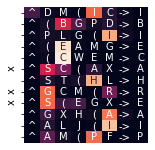

In [5057]:
a = globalize(attentions[layer2])[:, head2]
# a = a.softmax(-1)
a = torch.cat([a[:, i - 1: i, i - ncols - 2: i + 1] for i in ans_positions], dim=1)
# a = a.softmax(-1)
loss = a.view(a.size(0), -1)[:, tgt_positions[1:]].mean(dim=1)
print(loss)
plot_tgt_attn(a[0])

In [3455]:
wvos = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(11, 8), (12, 18)]]
wqk = torch.matmul(*get_head_weights(13, 2)[:2])
ww = wvos[0].matmul(wvos[1]).matmul(wqk)

In [3735]:
ww.norm(dim=0).topk(40).indices

tensor([2484,   88,  578, 1781,  586,  408, 2054,  304,  824, 1675, 1772,  501,
        2456, 1019,  936, 2463, 2368,  340, 2418,  101, 1734,  687, 2159, 1060,
          20, 1838,  224, 1669, 1187,  870, 1585,  232,  281, 1474, 1729,  328,
        1860, 1174,  816, 1524])

In [3741]:
show_topk(*aw.view(-1).topk(20, largest=False), indices_fn=indices_fn)

{(578, 586): -0.0016085216,
 (578, 88): -0.0011706072,
 (936, 1782): -0.0011014504,
 (578, 501): -0.0009034774,
 (578, 114): -0.00086396607,
 (578, 1761): -0.00080681103,
 (578, 1067): -0.0007989705,
 (936, 814): -0.00079893926,
 (936, 405): -0.00076955673,
 (936, 336): -0.0007586547,
 (578, 2149): -0.00074234203,
 (578, 1666): -0.0007264766,
 (578, 408): -0.00071433355,
 (578, 1019): -0.00066249806,
 (936, 946): -0.00065255526,
 (2484, 1675): -0.00064498984,
 (578, 1675): -0.0006330121,
 (578, 1651): -0.00062471436,
 (936, 1445): -0.00062095723,
 (578, 289): -0.0006184878}

In [4065]:
wvos2 = [torch.matmul(*get_head_weights(l, h)[2:]) for l, h in [(9, 9), (10, 1), (12, 18)]]
ww2 = reduce(torch.matmul, wvos2 + [wqk])

In [5015]:
attn_output1, out = None, None
out_proj_w = self1.out_proj.weight.view(hidden_size, H, -1).permute(1, 2, 0).unsqueeze(0)
head_mask = torch.zeros(H, seq_len, seq_len)
head_mask[[18,]] = 1
# head_mask[:] = 1
attn1 = attentions[layer1]
_attn1, __attn1 = torch.zeros_like(attn1), torch.zeros_like(attn1)
for i in range(0, nrows):
    _attn1[:, :, arrow_positions[i], ans_positions[i]] = 1
    __attn1[:, :, arrow_positions[i], ans_positions[:i]] = 1 / i if i > 0 else 0
    
def ffn(layer, x): return blocks[layer].mlp(blocks[layer].ln_2(x))

def tgt_attn_loss(h1, attn1, key0, residual=None, attn_output_w=1, apply_softmax=True, temperature=10, 
                  positions=tgt_positions, plot=False, ax=None):
    def get_attn(attn_output):
        out = (residual if residual is not None else 0) + attn_output * attn_output_w
        if residual is not None: out = out + ffn(layer1, out)
        if residual is not None: out = ln2(out)
        query = out.matmul(wq2.t()).unsqueeze(2) # (bsz, nrows, d_head) -> (bsz, nrows, 1, d_head), ln2 is omissible
        key = key0.matmul(wk2.t()).view(bsz, nrows, ncols + 3, hidden_size // H)
        a = (query * key).sum(-1) # (bsz, nrows, ncols + 3)
        a[:, :, [-1]] = -1e9
        if apply_softmax: a = (a / temperature).softmax(-1)
        return a

    self1.w = attn1 * head_mask; attn_output1 = self1(h1)[0] - self1.out_proj.bias
    a = get_attn(attn_output1[:, arrow_positions])
    loss = a.view(a.size(0), -1)[:, positions]
    if plot:
#         a = a - a.min(dim=2, keepdim=True).values
        plot_tgt_attn(a[0], ax=ax)#; print(loss)
    return loss.mean()

residual = None or hidden_states[layer1][:, arrow_positions]

[0.7721180319786072, 0.9933991432189941, 0.9961371421813965]

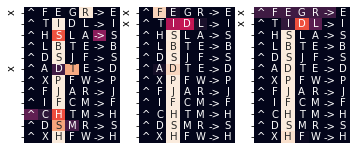

In [5052]:
def get_ln(layer): return blocks[layer].ln_1
# 10-ffn, 9-11 for find special, 9-11 for AbCD->B/b, 9-11 for ABCD->C
# 10-19+ffn+8!, 9-11 for after bracket 5-5/7, 9-11, 10-1+13+ffn+8+19 for in brackets
mask = torch.zeros(H, seq_len, 1); mask[11] = 1#; mask[:] = 0 # 11-8, 10-1, 9-11,   9-11/6?->8-17 for 2nd
# for i in range(0, nrows): mask[1, ans_positions[i], tgt_positions[i]+1] = 1
layer0 = 9
self0, ln0 = get_attn_module(blocks[layer0]), blocks[layer0].ln_1

h0 = hidden_states[9]*0 + head_outputs[8][:, [17]].sum(1)*1
self0.w = attentions[layer0] * mask; attn_output0 = self0((h0), attention_masks[layer0])[0] - self0.out_proj.bias
# h1 = hidden_states[9]*0 + head_outputs[11][:, [8]].sum(1)*1 #+ ffn_outputs[10]#+ head_outputs[11][:, [8,]].sum(1)*1
# h1 = ln1(h1)
h1 = attn_output0
key0 = get_ln(10)(hidden_states[10])#; key0.reqires_grad = True; key0.retain_grad()
fig, axes = plt.subplots(1, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24))
# loss = tgt_attn_loss(h1, __attn1, key0, residual=None, plot=True, apply_softmax=True, temperature=1, ax=axes[0]); loss
# print('after', key0[:, :, 0])
[tgt_attn_loss(h1, attn, key0, residual=None,plot=True,temperature=1, positions=tgt_positions[(i>0)*2:],ax=ax).item() 
    for i, (attn, ax) in enumerate(zip([_attn1, attn1, __attn1], axes))]
# if losses[0] > 0.8 and losses[-1] > 0.8: print(layer, head, losses)

In [5075]:
def get_weight_norm(w):
    return w.abs().mean().item()

In [5083]:
wvo1 = get_combined_w(9, 11) * get_combined_w(12, 18)
for layer in [8, ]:
    for head in range(H):
        wvo = get_combined_w(layer, head)
        print('%d-%d %.4f %.4f' % (layer, head, get_weight_norm(wvo.matmul(wvo1)) / get_weight_norm(wvo), get_weight_norm(wvo.matmul(wvo1))))

8-0 0.0865 0.0030
8-1 0.0865 0.0016
8-2 0.0866 0.0026
8-3 0.0870 0.0027
8-4 0.0867 0.0019
8-5 0.0873 0.0022
8-6 0.0874 0.0027
8-7 0.0867 0.0023
8-8 0.0867 0.0021
8-9 0.0879 0.0026
8-10 0.0874 0.0023
8-11 0.0866 0.0024
8-12 0.0870 0.0024
8-13 0.0868 0.0023
8-14 0.0866 0.0017
8-15 0.0870 0.0023
8-16 0.0874 0.0029
8-17 0.0865 0.0014
8-18 0.0876 0.0025
8-19 0.0866 0.0024


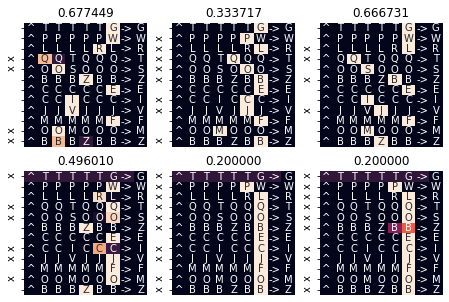

In [4950]:
front_chains = [
    [[(11, 8), create_mask(ans_positions, tgt_positions)]],
    [[(9, 9), create_mask(tgt_positions + 1, tgt_positions)], [(10, 1), create_mask(ans_positions, tgt_positions + 1)]],
]
rear_chains = [
    [[(12, 18), create_mask(arrow_positions, ans_positions)], [(13, 2), None]],
    [[(12, 18), create_mask(arrow_positions, ans_positions, accum=True)], [(13, 2), None]],
]

sum_a = {i: 0 for i in range(len(rear_chains))}
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for j, front_chain in enumerate(front_chains):
    l0 = front_chain[0][0][0]
    h = h0 = get_ln(l0)(hidden_states[l0])
    for (layer, head), mask in front_chain:
#         attn = globalize(attentions[layer])[:, head] #if layer in [9] else mask
        attn = mask
        wvo = get_combined_w(layer, head)
        h = attn.matmul(h.matmul(wvo))
    for i, rear_chain in enumerate(rear_chains):
        (layer, head), mask = rear_chain[0]
        attn = mask
        wvo = get_combined_w(layer, head)
        q = attn.matmul(h.matmul(wvo))
        wqk = get_combined_w(*rear_chain[-1][0], qk=True)
        q = q.matmul(wqk)[:, arrow_positions].unsqueeze(2)
        k = h0.view(h0.size(0), nrows, ncols + 3, hidden_size)
        a = q.matmul(k.transpose(-1, -2)).squeeze(2) / 1
        a[:, :, [-1]] = -1e9
        sum_a[i] = sum_a[i] + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j], title='%f' % loss.item())

for i in range(len(rear_chains)):
    a = sum_a[i]
    a = a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean()#; print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2], title='%f' % loss.item())

In [4602]:
_sattn, __sattn = torch.zeros(1, seq_len, seq_len), torch.zeros(1, seq_len, seq_len)
for i in range(0, nrows):
    _sattn[:, arrow_positions[i], tgt_positions[i]] = 1
    __sattn[:, arrow_positions[i], tgt_positions[:i]] = 1 / i if i > 0 else 0

0.157 0.497 0.250 
0.100 0.809 0.264 


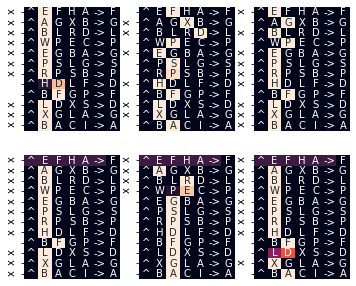

In [4605]:
ww0 = torch.eye(hidden_size)
# layer = 9; ln = blocks[layer].ln_1
# h0 = key0 = ln(hidden_states[layer])
fig, axes = plt.subplots(2, 3, sharey=False, figsize=(2.5 * (ncols + 3) / 9 * 3, 5 * nrows / 24 * 2))
for i, attn in enumerate([_sattn, __sattn]):
    sum_a = 0
    for j, (w, layer) in enumerate([(ww, 11), (ww2, 9)]):
        ln = blocks[layer].ln_1
        h0 = key0 = ln(hidden_states[layer])
        query = attn.matmul(h0)[:, arrow_positions].matmul(w).unsqueeze(2)
        key = key0.view(key0.size(0), nrows, ncols + 3, hidden_size)
        a = (query * key).sum(-1) / 1
        a[:, :, [-1]] = -1e9
        sum_a = sum_a + a
        a = a.softmax(-1)
        loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
        plot_tgt_attn(a[0], ax=axes[i, j])
    a = sum_a.softmax(-1)
    loss = a.view(a.size(0), -1)[:, tgt_positions[i*2:]].mean(); print('%.3f' % loss.item(), end=' ')
    plot_tgt_attn(a[0], ax=axes[i, 2])
    print()

In [3719]:
aw = ww * ww.grad

In [3721]:
aw.norm(dim=0).topk(10)

torch.return_types.topk(
values=tensor([0.0037, 0.0029, 0.0027, 0.0025, 0.0023, 0.0023, 0.0018, 0.0016, 0.0016,
        0.0016], grad_fn=<TopkBackward>),
indices=tensor([  88,  586, 2484,  408, 1782,  578, 1781, 1019,  405, 1761]))

In [4962]:
head_outputs[9][0, :, ans_positions].norm(dim=-1).mean(-1).topk(10)

torch.return_types.topk(
values=tensor([12.2424, 11.6219, 11.3335, 10.7489,  9.3170,  9.2139,  8.5213,  7.5385,
         6.7957,  6.3538]),
indices=tensor([ 9, 19, 11,  7, 14,  6,  4, 10,  0,  8]))

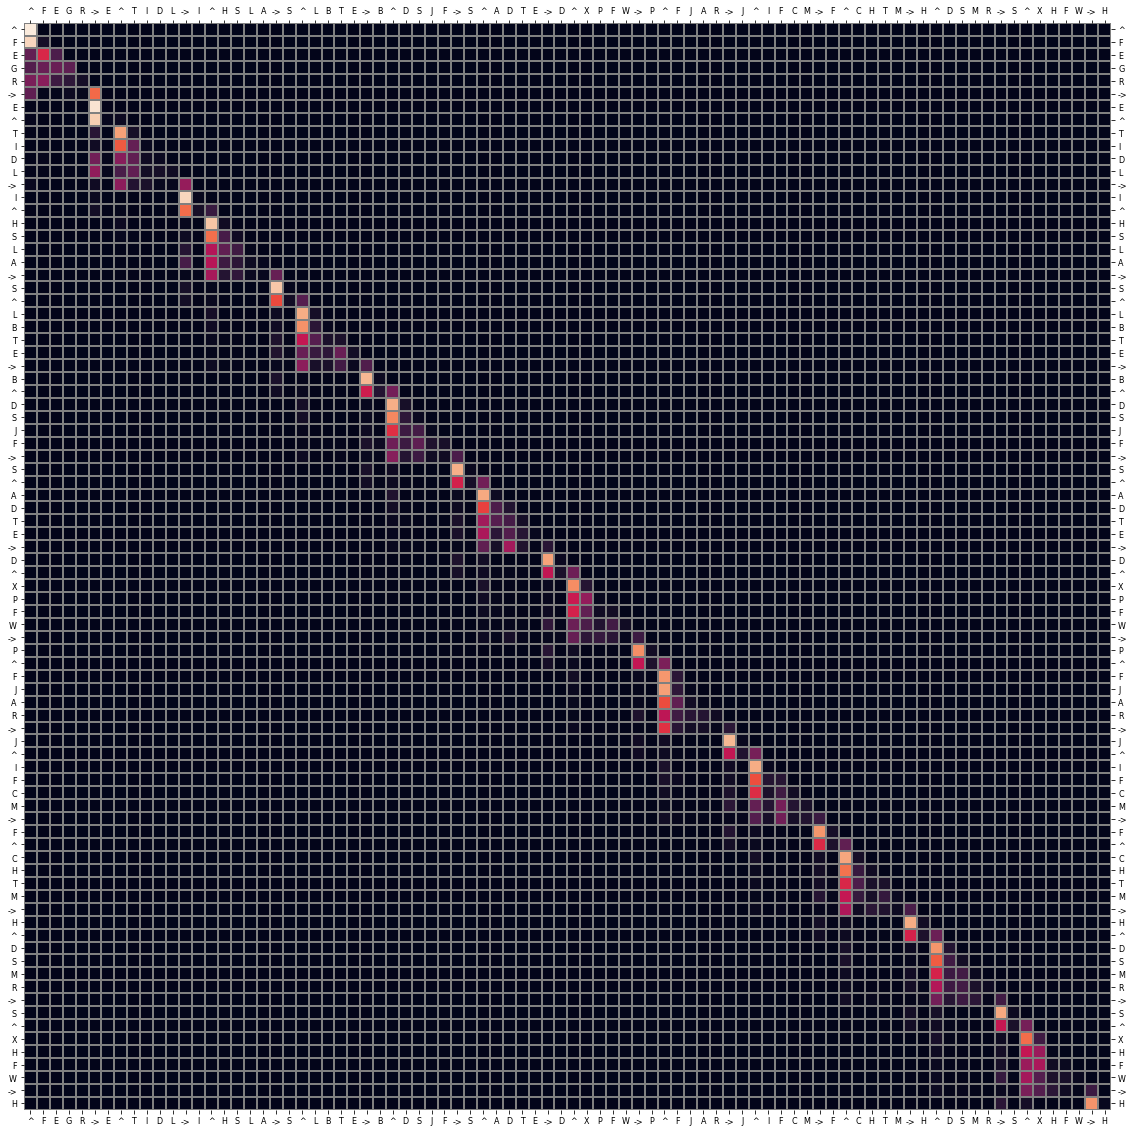

In [5037]:
plot_attn(globalize(attentions[9])[0, 6], figsize=(20, 20))

In [3360]:
a0 = head_outputs[9][0, 11, ans_positions]
a1 = head_outputs[11][0, 8, ans_positions]

In [3362]:
a0 = attrs['head_output'][9, 11, ans_positions]
a1 = attrs['head_output'][11, 8, ans_positions]

In [3363]:
cos = nn.CosineSimilarity(dim=1)
cos(a0, a1)

tensor([0.0226, 0.1145, 0.0712, 0.1595, 0.0533, 0.0150, 0.1125, 0.1410, 0.0172,
        0.0142, 0.0040, 0.0719])

In [3336]:
attr = attrs['attn_output'].sum(-1)
attr = attr / attr.view(attr.size(0), -1).norm(dim=1)[:, None]

<AxesSubplot:>

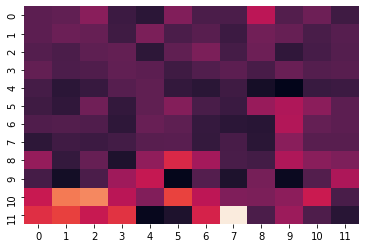

In [3337]:
sns.heatmap(numpy(attr[:, ans_positions]), cbar=False)

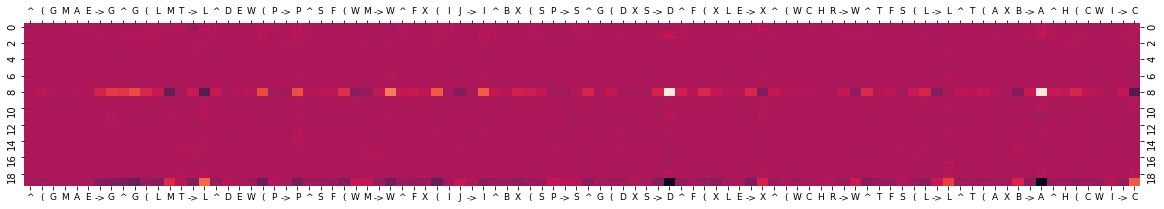

In [3887]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attrs['head_output'].sum(-1)[10]), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

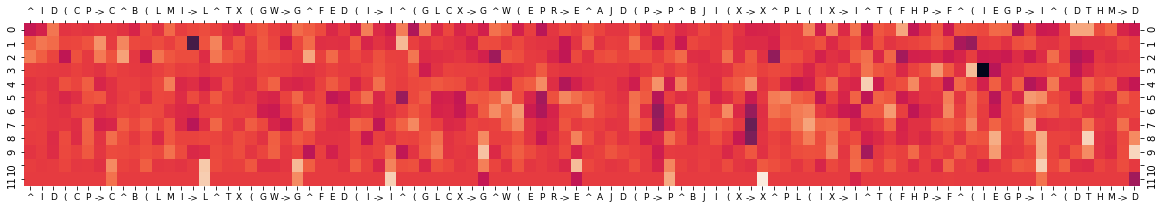

In [3303]:
_ = plt.figure(figsize=(20, 3))
ax = sns.heatmap(numpy(attr), cbar=False, xticklabels=tokens)
_ = ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=9, rotation=0)
ax.tick_params(top=True, right=True, labeltop=True, labelright=True)

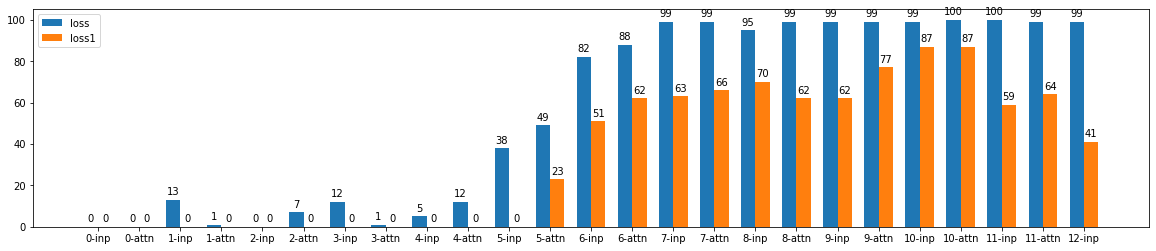

In [616]:
ffn_w = 0
results = []
for i in range(0, layer1 + 1):
    h1 = hidden_states[i] - hidden_states[0]*1
    residual = None #or hidden_states[layer1][:, arrow_positions]
    losses = [tgt_attn_loss(h1, attn, residual=residual, ffn_w=ffn_w) for attn in [_attn1, attn1]]
    results.append(('%d-inp' % i, losses[0], losses[1]))
    if i < layer1:
        losses = [tgt_attn_loss(h1 + attn_outputs[i], attn, residual=residual, ffn_w=ffn_w) 
                  for attn in [_attn1, attn1]]
        results.append(('%d-attn' % i, losses[0], losses[1]))
plot_tgt_attn_losses(*zip(*results))

10 tensor(0.2207, grad_fn=<MeanBackward0>)


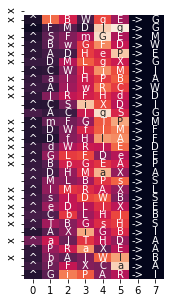

In [2149]:
a = []
tgt_h = hidden_states[layer0][0, tgt_positions]
h0 = hidden_states[layer0].view(nrows, ncols + 3, hidden_size)
for i in range(nrows):
    q = tgt_h[0:i].mean(dim=0)
    q = ln2(q).matmul(wq2.t())
    k = ln2(h0[i]).matmul(wq2.t())
#     attn1 = globalize(attentions[layer1]) * head_mask
#     attn_output1 = torch.matmul(attn1, _head_output1).sum(1)
#     q = ln2(attn_output1[:, arrow_positions[i]]).matmul(wq2.t())
#     q = ln2(_attn_output1[:, ans_positions][:, i:i+1].mean(1)).matmul(wq2.t())
#     k = key[i]
    a.append((q * k).sum(-1).unsqueeze(0))  # == torch.matmul(q, k.t())

a = torch.cat(a)
a[:, -2:] = -1000000
a = a.softmax(-1)
plot_tgt_attn(a)

In [3153]:
layer1, head1 = 12, 18
layer0, head0 = 11, 8
layer2, head2 = 13, 2  #17-4 for A[B]C->B,A*BC->B, 13-5 for reverse set diff
self0, self1, self2 = get_attn_module(blocks[layer0]), get_attn_module(blocks[layer1]), get_attn_module(blocks[layer2])

h_mask = torch.ones(hidden_size)
h_mask[top_i[0]] = 0

ln0, ln1, ln2 = blocks[layer0].ln_1, blocks[layer1].ln_1, blocks[layer2].ln_1
# mean, var = forward(blocks[layer2], 'ln1_mean_var')

wq0, wk0, wv0, wo0 = get_head_weights(layer0, head0)
wq1, wk1, wv1, wo1 = get_head_weights(layer1, head1)
wq2, wk2, wv2, wo2 = get_head_weights(layer2, head2)

In [3396]:
attn_output0, ffn_output0 = forward(blocks[layer0], ['attn_output', 'ffn_output'], exit_module=blocks[layer0],
                                    extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])
head_output0 = forward(get_attn_module(blocks[layer0]), 'head_output', exit_module=blocks[layer0],
                        extra_tuples=[(get_attn_module(blocks[layer0]), 'hidden_states_mask', h_mask)])

10


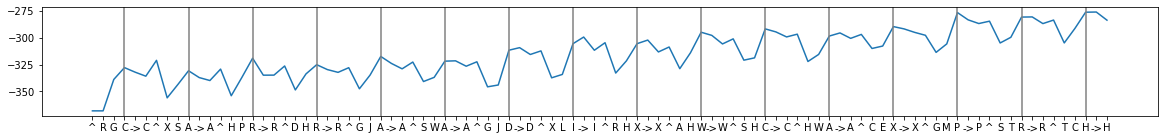

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
 tensor(1.0000, grad_fn=<MeanBackward0>)


In [1202]:
## h1 = ln1(hidden_states[10]*0 + attn_output0 * 1 + ffn_output0 * 1)
h1 = ln1(hidden_states[layer0]*1 + attn_outputs[10]*1 + ffn_outputs[10] * 1 + attn_outputs[11] * 1 + ffn_outputs[11] * 1)

self1.head_output, self1.attn_output = None, None
self1.w = attentions[layer1]
try: _ = self1(h1, attention_mask=attention_masks[layer1])
finally:
    head_output1, attn_output1 = getdelattr(self1, 'head_output'), getdelattr(self1, 'attn_output')
    try_delattr(self1, 'w')

query = get_query(self2, ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*0))
# query = get_query(self2, ln2(head_output1[:, [16, 18]].sum(1)))
# query = get_query((self2, head_outputs[layer1][:, head1]))
# query = get_query(self2, attn_hidden_states[layer2])
for layer in [layer0]:#range(layer2 + 1):
    key2 = get_key(self2, ln2(hidden_states[layer]))
#     key2 = get_key(self2, ln2(attn_outputs[9]))
    logits = (query * key2).sum(dim=-1)
    print(layer)
    _ = test(None, None, logits=logits, always_show=True)

In [73]:
emb = all_embs[task_name][key]
emb_attr = all_attrs[task_name][key + str(int(pred_attn))]

In [2881]:
layer0 = 10
# layer, head = 10, 8  # ABC->B, ABC->A(pred_attn<12-18), ABC->C(only pred_attn), find lowercase, set diff2(only pred_attn)
layer, head = 12, 18 # 12-16, 12-18, 12-1 ABC->A, ABC,AXC->X, set diff2, set diff
layer2, head2 = 13, 2  # ABC->B, ABC->A, ABC->C, ABC,AXC->X, set diff, set diff2(<13-12), find lowercase(<15-8)
# layer2, head2 = 15, 8  # 15-8, find lowercase
# layer2, head2 = 13, 12  # set diff2, ABC,AXC->X(<13-2)

In [483]:
positions = tgt_positions[1:]
offsets = [torch.zeros_like(positions) - 1, torch.zeros_like(positions), torch.zeros_like(positions) + 1]
labels = numpy(torch.cat(offsets))
for layer in range(layer2):
    for head in range(H):
        emb = numpy(torch.cat([attn_outs[layer][0, head, positions + offset] for offset in offsets]))
#         emb = numpy(torch.cat([head_outputs[layer][0, head, positions + offset] for offset in offsets]))
        head_output = head_outputs[layer][:, head]
        if cluster(emb, labels)[0]:# and test(head_output, always_show=False) is not None:
#         if test(head_output, always_show=False) is not None:
            visualize_by_pca(emb, labels)
#             attn = globalize(attentions[layer])[0, head]
#             plot_attn(attn)
            print(layer, head)

(tensor([0.0174, 0.0392, 0.0546, 0.0641, 0.0408, 0.2807, 0.1289, 0.1209, 0.0977],
        grad_fn=<IndexBackward>),
 tensor(0.8444, grad_fn=<SumBackward0>))

(tensor([0.6571, 0.1062, 0.3671, 0.5548, 0.2617, 0.7426, 0.6988, 0.5396, 0.8236,
         0.6873], grad_fn=<SelectBackward>),
 tensor(0.5439, grad_fn=<MeanBackward0>))

(tensor([1.1355e-16, 3.7752e-13, 7.8185e-12, 6.1335e-10, 5.1372e-08, 3.3332e-06,
         3.1391e-04, 5.4327e-03, 1.5451e-01, 5.4892e-01],
        grad_fn=<IndexBackward>),
 tensor(0.0709, grad_fn=<MeanBackward0>))

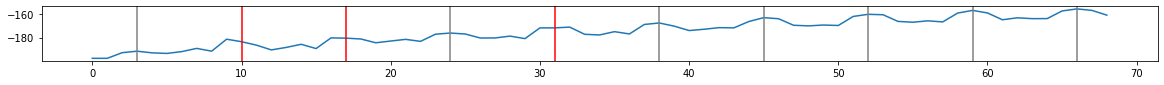

True

In [2023]:
layer0, head0 = 10, 1 #11-14  10-1
h_mask2 = torch.ones(hidden_size)
h_mask2[top_i[:]] = 0

attn_mask = torch.ones(H, seq_len, hidden_size // H)
# attn_mask[:, :] = 0
# attn_mask[8, :] = .1
m = get_attn_module(blocks[layer2])
outputs = forward(get_attn_module(blocks[layer0]), 'attn_mask', attn_mask, exit_module=blocks[layer2],
                 extra_tuples=[(m, 'return_attn_logits', True), #(m, 'hidden_states_mask', h_mask2),
#                                (get_attn_module(blocks[10]), 'hidden_states_mask', h_mask2),
                               (get_attn_module(blocks[layer1]), 'w', attentions[layer1])
                              ])

probs0 = outputs.attentions[layer1][0, head1, src, ans_positions[:-1]]
probs0, probs0.sum()
logits = globalize(outputs.attentions[layer2])[0, head2, src, : src + 1]
probs = logits[cand_positions].view(-1, n_candidates).softmax(-1)[:, task_name2idx[task_name]]
probs, probs.mean()
probs = logits.softmax(-1)[tgt_positions]
probs, probs.mean()
test(None, None, logits=logits)

tensor([[0.0066, 0.0076, 0.1356, 0.0835, 0.2636, 0.0631, 0.2177]],
       device='cuda:2')
tensor([0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143, 0.0143],
       device='cuda:2')
{'44 a': 0.3398, '42 ^': 0.2043, '43 Y': 0.1879, '38 I': 0.0659, '41 v': 0.0539}


{'Ġa': 0.3382, 'Ġv': 0.2697, 'ĠY': 0.0545, 'Ġu': 0.042, 'Ġy': 0.0365}

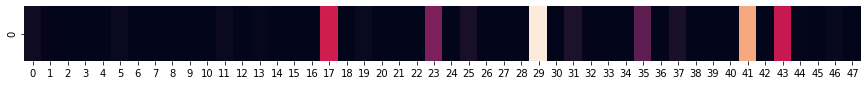

In [261]:
m = blocks[layer].attn.attention
mask = torch.ones(H, seq_len, seq_len)
# mask[:, src] = 0
mask[:] = 0
mask[head, src] = 0.1
_ = mask.requires_grad_(True)
# m.attn_mask = mask

# scaled_attn = attentions[layer] * mask.to(model.device)
# _ = scaled_attn.requires_grad_(True)
# m.w = scaled_attn
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
    attn = outputs.attentions[layer]
    _ = plt.figure(figsize=(15, 1))
    _ = sns.heatmap(numpy(attn[:, head, src, :]), cbar=False)
    print(attn[:, head, src, ans_positions[:-1]])
    
    attn[:] = 0
#     attn[0, head, src] = 0
    attn[0, head, src, ans_positions[:-1]] = 0.1 / len(ans_positions[:-1])
#     i = random.randint(0, attn.size(3) - 1); i
#     attn[0, head, src] = 0.1 / attn.size(3)
    print(attn[0, head, src, ans_positions[:-1]])
    m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     outputs = model(**inputs, output_attentions=True)
finally:
#     m.attn_mask = None
    m.w = None
# y = outputs.logits.softmax(-1)[:, src, pred_label]
# mask_grad = torch.autograd.grad(torch.unbind(y), mask)[0]
# attn_grad = torch.autograd.grad(torch.unbind(y), scaled_attn)[0]
    
attn = globalize(outputs.attentions[layer2])[0, head2, src]
print(show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions))
probs = outputs.logits[0, src].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

In [209]:
attn_grad[0, head - 2].mean()

tensor(0.0001, device='cuda:2')

In [169]:
attn_grad.size()
attn_grad2.size()
(attn_grad2[4:5] - attn_grad).abs().max()
attn_grad[0, head, src, ki]
attn_grad2[4, head, src, ki]

torch.Size([1, 20, 72, 72])

torch.Size([10, 20, 72, 72])

tensor(6.2585e-05, device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

tensor([-0.2539, -0.2229, -0.2132, -0.1997, -0.1915, -0.1745, -0.1862],
       device='cuda:2')

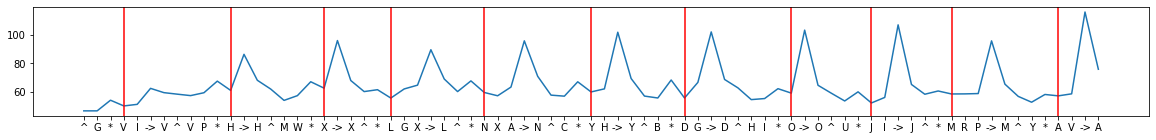

[0.017 0.002 0.011 0.    0.    0.001 0.    0.044 0.    0.088 0.13 ] 
 tensor(0.0266, grad_fn=<MeanBackward0>)


In [3504]:
qh = ln2(hidden_states[layer1]*0 + attn_output1*1 + attn_outputs[13]*1)[:, src:src+1]
kh = attn_hidden_states[layer2]
# kh = ln2(attn_outputs[9])
logits = (qh * kh).sum(dim=-1).squeeze(0)
_ = test(None, None, logits=logits, always_show=True)

In [11]:
texts = {
    'find lowercase': '''
X C e -> e
S f Z -> f
K y N -> y
q M N -> q
u S N -> u
S v Y -> v
v I J -> v
Y a N -> a''',
    'AbC->B': '''
X C e -> E
S f Z -> F
K y N -> Y
q M N -> Q
u S N -> U
S v Y -> V
g I J -> G
Y a N -> A
L n J -> N
d H I -> D
Z r C -> R
U S t -> T
K r A -> R
I G m -> M
t O X -> T''',  # failed, but GPT-3 can with low prob
    'set diff': '''
G L C, G L -> C
Y P J, Y P -> J
E S A, S A -> E
U P W, U P -> W
W Z A, W A -> Z
Z Q J, Z J -> Q
C Y L, Y L -> C
C K Z, C Z -> K
K O Q, O Q -> K
K O N, K N -> O
R U P, R P -> U
X C J, X C -> J
B G V, G V -> B
H V L, H V -> L
J K M, J M -> K
N W K, W K -> N
F B D, F B -> D''',
    'find majority': '''
n d d -> d
f f d -> f
e b e -> e
s q s -> s
d d o -> d
c e e -> e
g t g -> g
i i w -> i''', # basically failed
    'find special': '''
n d d -> n
f f d -> d
e b e -> b
s q s -> q
d d o -> o
c e e -> c
g g t -> t
w i i -> w''',  # failed, GPT-3 failed, too
    'find special2': '''
n d d d -> n
f f f d -> d
e b e e -> b
s s q s -> q
d d d o -> o
e c e e -> c
g g g t -> t
w i i i -> w''',  # failed, but GPT-3 can
    'ABC,AXC->X': '''
D O Q, K O Q -> K
K H N, K O N -> O
R X P, R U P -> U
X C G, X C J -> J
Z G V, B G V -> B
H V T, H V L -> L
J E M, J K M -> K
A W K, U W K -> U
F B Y, F B D -> D''',
    'reverse set diff': '''
O Q, K O Q -> K
K N, K O N -> O
R P, R U P -> U
X C, X C J -> J
G V, B G V -> B
H V, H V L -> L
J M, J K M -> K
W K, N W K -> N
F B, F B D -> D''',
    'set diff2': '''
Z Y, y -> z
K B, b -> k
N E, e -> n
J S, j -> s
O W, o -> w
F R, f -> r
J S, s -> j
N O, o -> n
P R, p -> r''',
    'find next': '''
W S D L, S -> D
F M W Q, F -> M
T W A V, A -> V
U V N M, N -> M
S D N O, S -> D
A S B T, S -> B
H W L Z, H -> W
C L J O, J -> O
T B A E, B -> A
L G C K, L -> G
G B S O, G -> B
K Y F O, F -> O
V Q U S, V -> Q
S E Y P, Y -> P
X D A U, A -> U
T L M N, L -> M
U O Y I, O -> Y''',  # failed, GPT-3 failed too
    'antonym': '''
big -> small
low -> high
fast -> slow
dark -> light
long -> short''',
}

In [ ]:
try:
#     with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
#     attn = outputs.attentions[layer]
#     print(attn[0, head, src, ans_positions[:-1]])
#     attn[0, head, src] = 0
#     attn[0, head, src, ans_positions[-8]] = 1
#     print(attn[0, head, src, ans_positions[:-1]])
#     m.w = attn
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    m.attn_mask = None
#     m.w = None

In [258]:
def norm(tensor): return round(tensor.abs().mean().item(), 4)
hidden_states.mean(), hidden_states.std()
for l in range(layer, layer2):
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].attn_output
    print(norm(h[l].attn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())
    print(norm(hidden_states), end=' ')
    hidden_states = hidden_states + h[l].ffn_output
    print(norm(h[l].ffn_output), norm(hidden_states), hidden_states.mean(), hidden_states.std())

(tensor(-0.7157, device='cuda:2'), tensor(17.1320, device='cuda:2'))

2.3035 0.7521 2.545 tensor(-0.7262, device='cuda:2') tensor(17.2453, device='cuda:2')
2.545 0.7547 2.7227 tensor(-0.7361, device='cuda:2') tensor(17.7049, device='cuda:2')
2.7227 0.7046 2.9372 tensor(-0.7366, device='cuda:2') tensor(17.8712, device='cuda:2')
2.9372 0.8032 3.1048 tensor(-0.7600, device='cuda:2') tensor(18.7369, device='cuda:2')
3.1048 0.8814 3.2894 tensor(-0.7694, device='cuda:2') tensor(18.9570, device='cuda:2')
3.2894 0.8759 3.2595 tensor(-0.7893, device='cuda:2') tensor(19.1697, device='cuda:2')


In [257]:
_hidden_states = h[layer2].ln_1(hidden_states)
try:
    with torch.no_grad(): _, attn = am2(am2_hidden_states, am2_attention_mask, output_attentions=True, q_hidden_states=_hidden_states)
finally: am2.q_hidden_states = None
attn = globalize(attn)
attn[0, head2, -1].topk(5)

torch.return_types.topk(
values=tensor([0.4904, 0.3162, 0.0501, 0.0432, 0.0416], device='cuda:2'),
indices=tensor([42, 43, 36, 44, 46], device='cuda:2'))

In [326]:
with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

for l in range(layer, layer + 1):
    mask_tgt_indices = [41, 35, 29, 23, 17, 11, 5]
    excluded_src_indices = [seq_len - 1] #if l == layer else []
    attn = outputs.attentions[l]
    if attn.dim() == 5:
        attn = attn[:, 0, :, :, -seq_len:] # (bsz, num_blokcs, H, seq_len, window_size + seq_len) -> (bsz, H, seq_len, seq_len)
#     for hd in range(H):
#         for src_idx in range(seq_len):
#             if hd != head and src_idx in excluded_src_indices:
#                 attn[:, hd, src_idx] = 0
    for hd in range(H):
        for src_idx in range(seq_len):
            for tgt_idx in range(seq_len):
                if hd == head and src_idx not in excluded_src_indices and tgt_idx in mask_tgt_indices:
                    attn[:, hd, src_idx, tgt_idx] = 0
    h[l].attn.attention.w = outputs.attentions[l]
try:
    with torch.no_grad(): outputs = model(**inputs, output_attentions=True)
finally:
    for l in range(layer, layer2):
        h[l].attn.attention.w = None
attn = globalize(outputs.attentions[layer2])[0, head2, -1]
show_topk(*attn.topk(5), indices_fn=append_tokens_to_positions)
probs = outputs.logits[0, -1].softmax(-1)
show_topk(*probs.topk(5), indices_fn=tokenizer.convert_ids_to_tokens)

{'44 E': 0.7865, '43 V': 0.1431, '38 K': 0.0355, '45 H': 0.0323, '37 A': 0.001}

{'ĠE': 0.8562, 'ĠH': 0.1216, 'ĠV': 0.0133, 'ĠD': 0.0009, 'ĠI': 0.0007}

{'28 ->': 0.6616,
 '40 ->': 0.3003,
 '22 ->': 0.0244,
 '34 ->': 0.013,
 '16 ->': 0.0003}

{'ĠT': 0.2914, 'ĠC': 0.1015, 'ĠL': 0.0839, 'ĠY': 0.0793, 'ĠE': 0.0643}

In [70]:
head_attrs = all_attrs['A B C D -> a'].sum(dim=(2, 3))
# head_attrs = attrs.sum(dim=(2, 3))

values, indices = head_attrs[:, :].view(-1).topk(10)
indices = unravel_index(indices, head_attrs.size())
top_heads = [(l, h, round(v, 8)) for l, h, v in zip(
    indices[0].tolist(), indices[1].tolist(), values.tolist())]
top_heads

[(17, 1, 1.08707237),
 (19, 21, 1.00648546),
 (21, 13, 0.78149551),
 (17, 10, 0.68284625),
 (17, 15, 0.63359404),
 (18, 18, 0.62241864),
 (22, 15, 0.52263898),
 (20, 5, 0.45230082),
 (19, 17, 0.36873266),
 (21, 4, 0.33636701)]

In [26]:
inputs = tokenizer.encode_plus(_text, return_tensors='pt')
outputs = model(**inputs, output_attentions=True)

logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
y = logits[0, -1].max()
attentions = outputs.attentions if hasattr(outputs, 'attentions') else outputs[-1]
for a in attentions: a.retain_grad()
model.zero_grad()
y.backward()

# attns = torch.cat(attentions)
grads = torch.cat([a.grad for a in attentions])
attrs2 = attns * grads

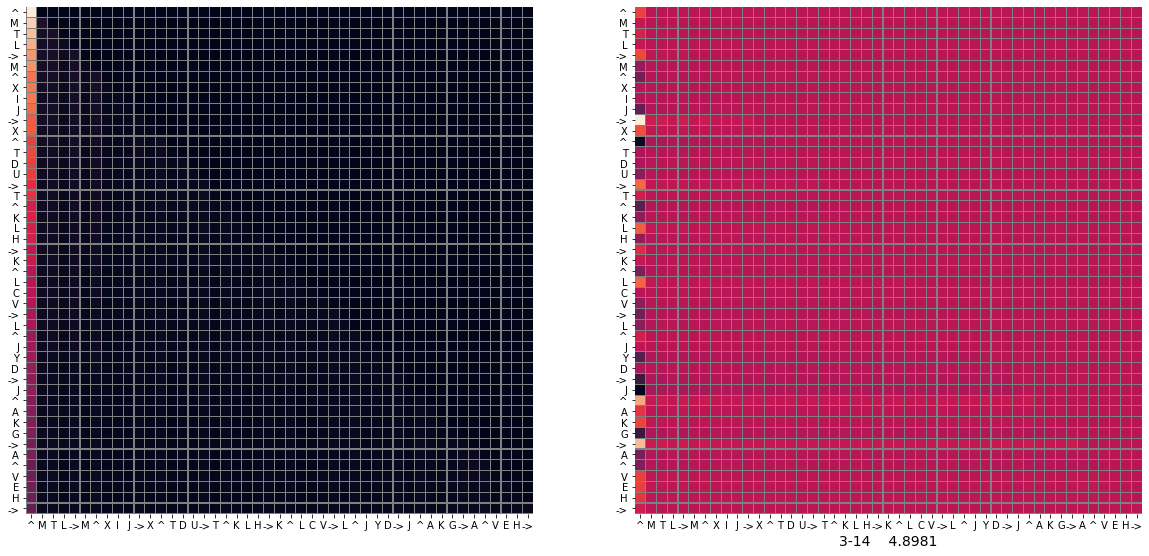

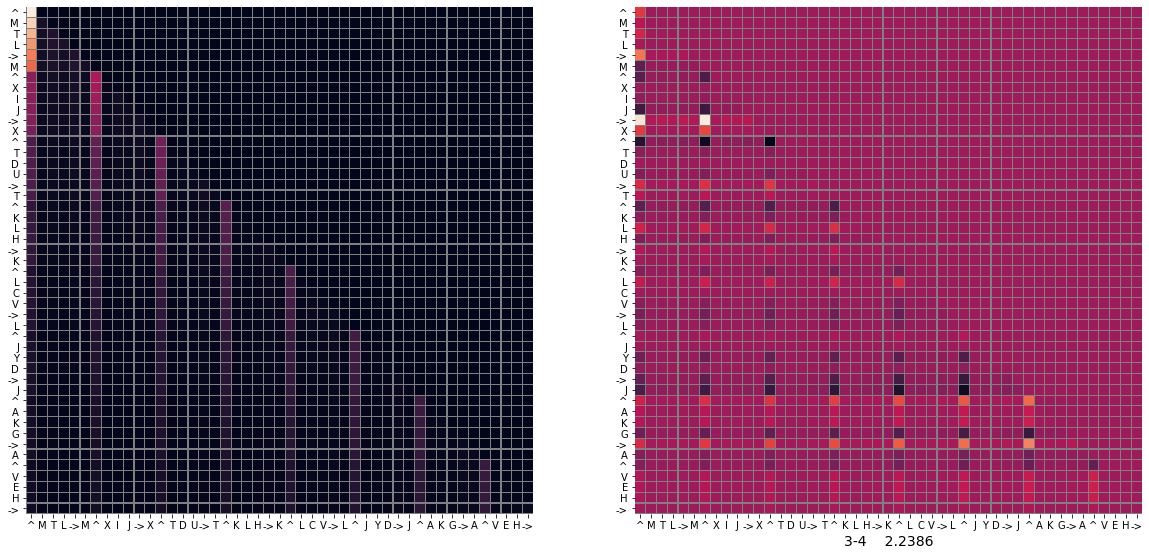

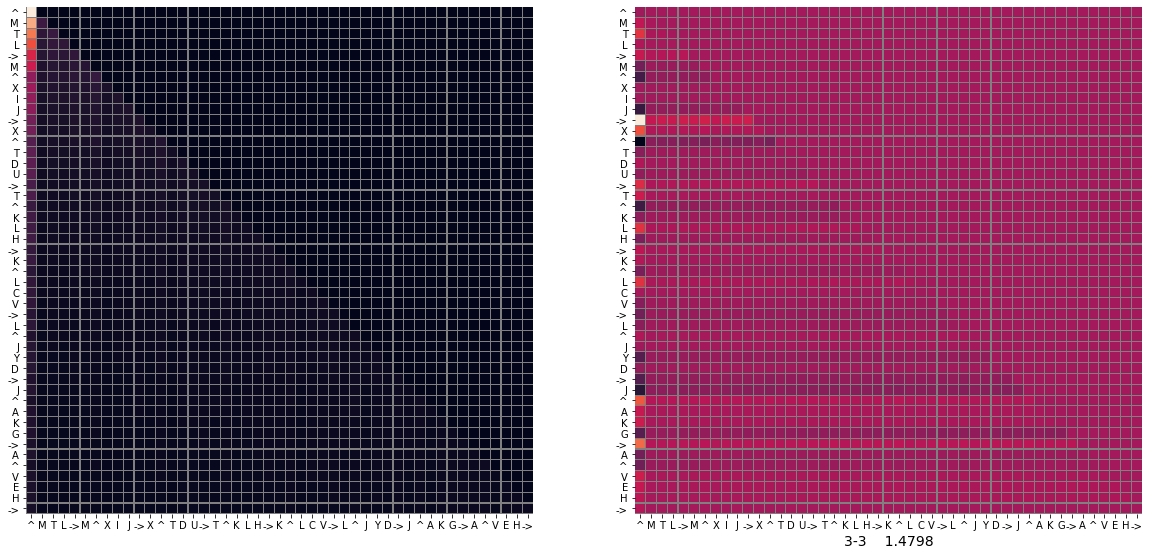

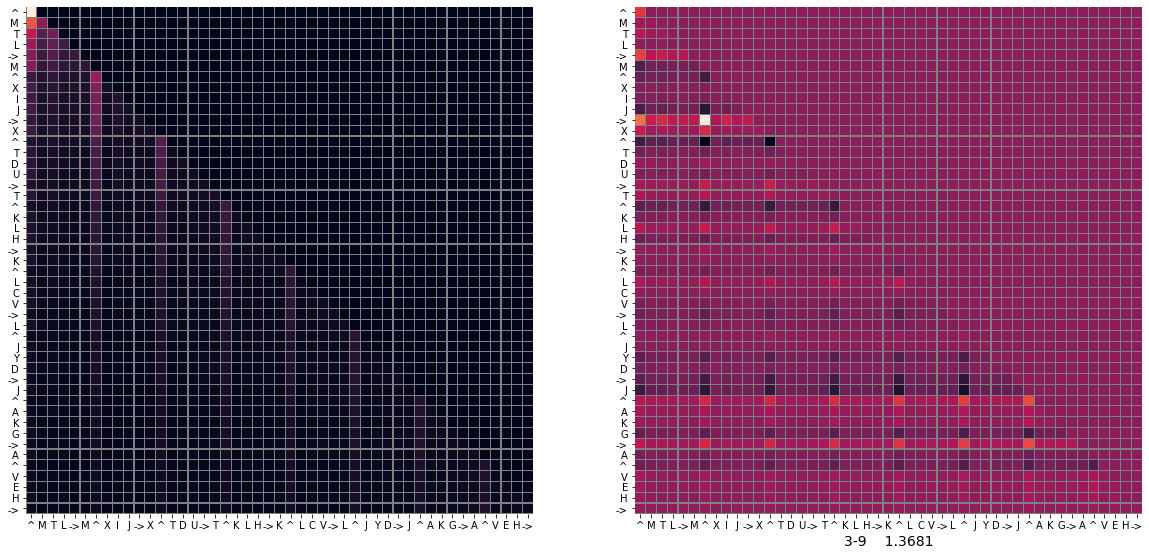

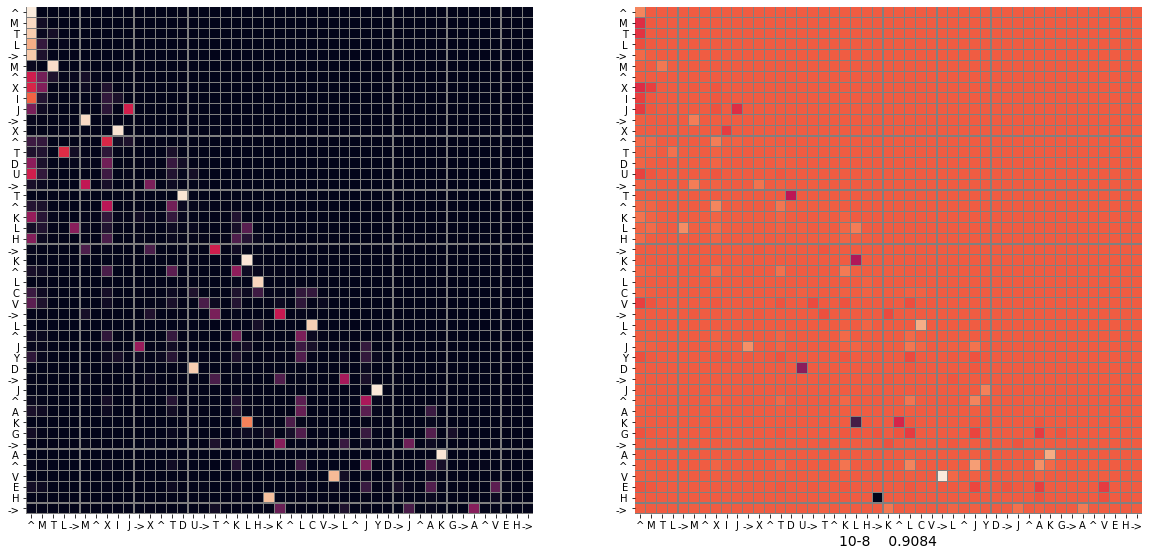

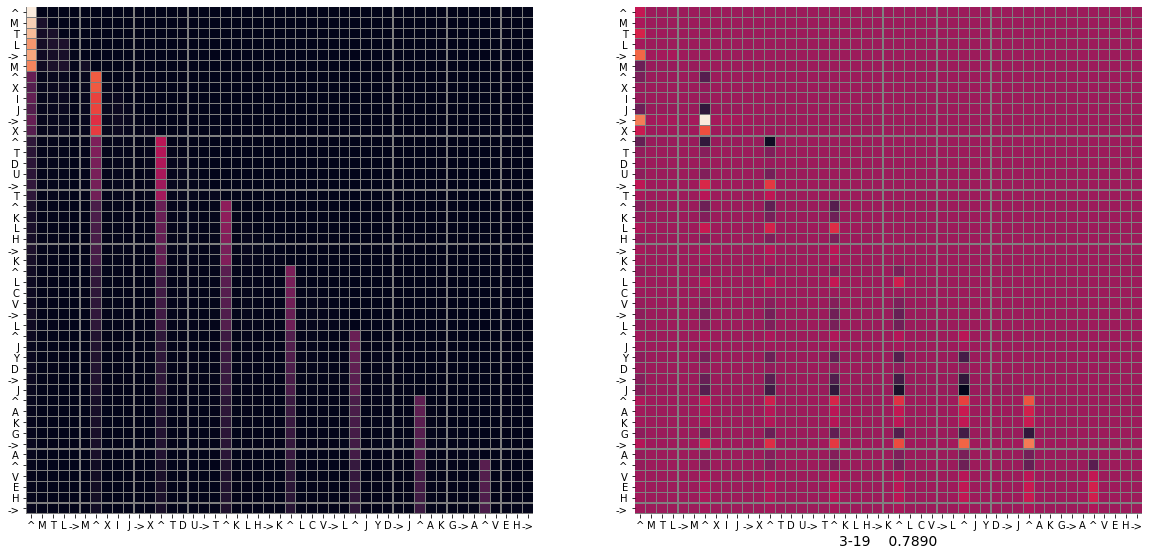

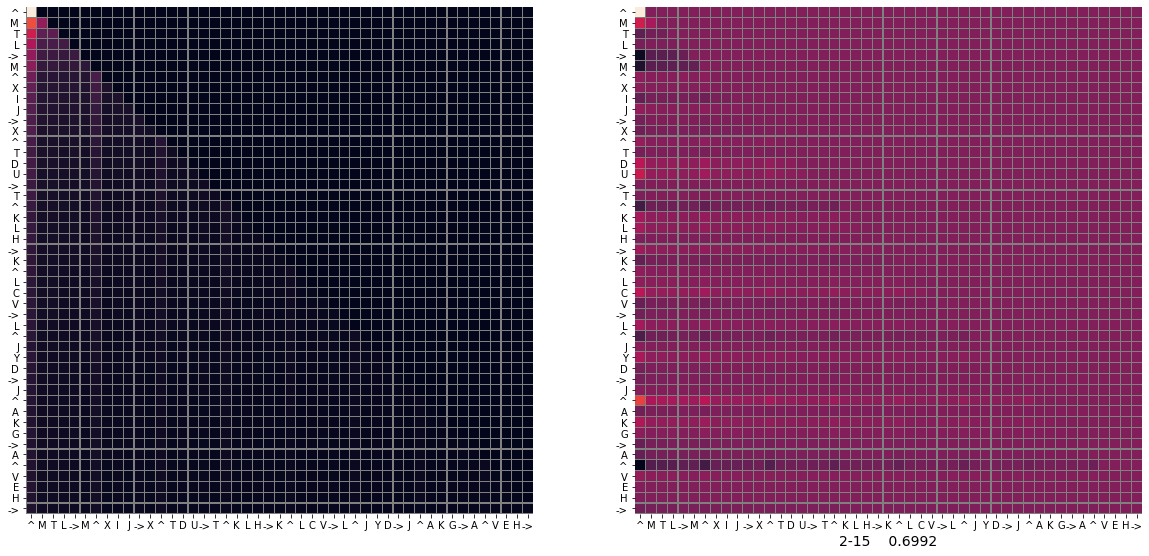

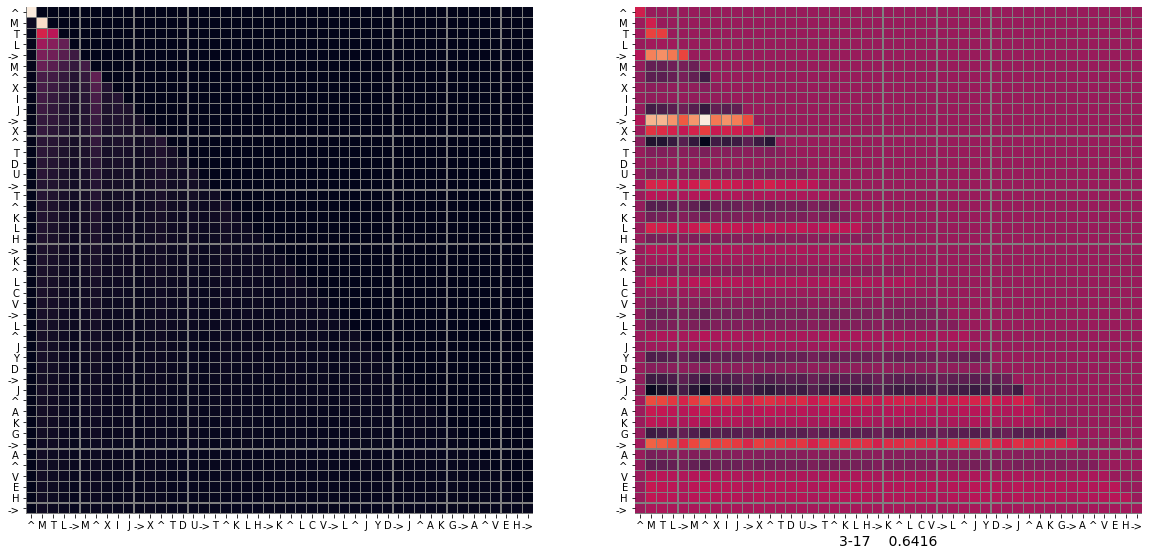

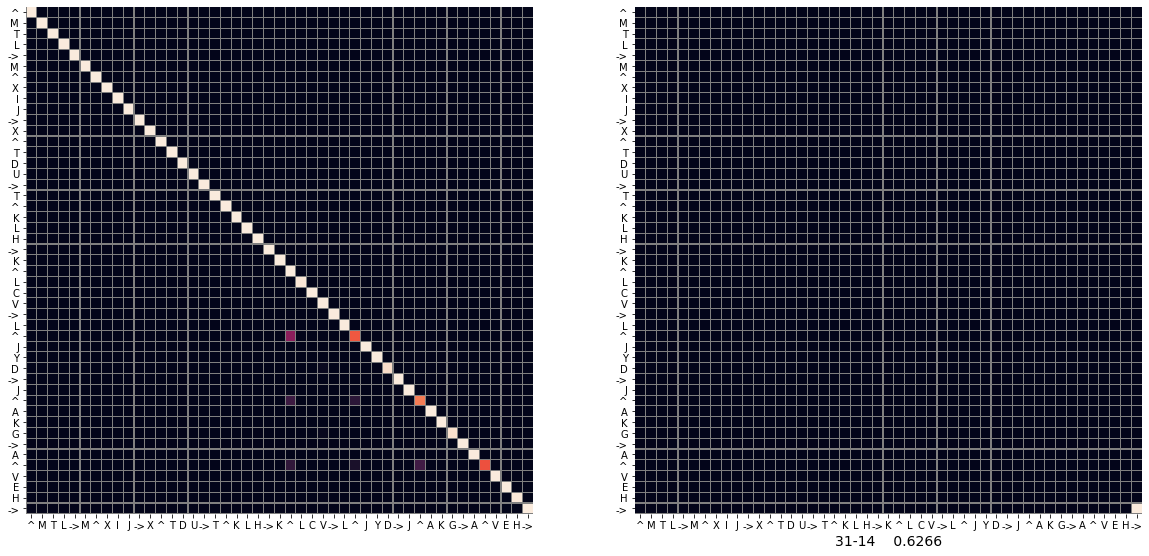

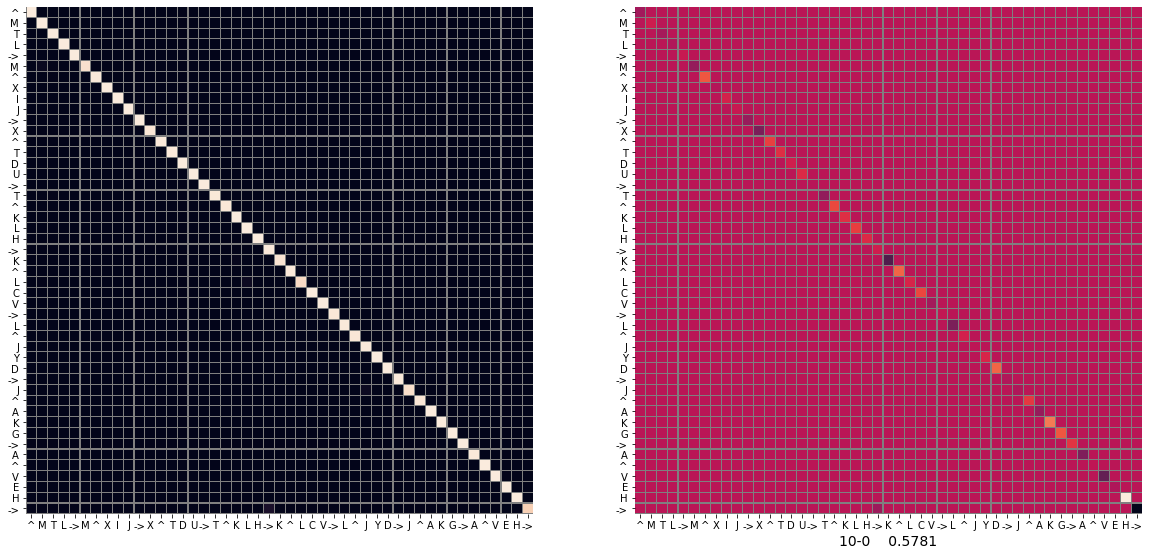

In [259]:
for i in range(len(top_heads)):
    layer, head, v, _ = top_heads[i]
    if layer in [0, 1, ]: continue
#     layer, head, v = 30, 10, 1.
    fig, axs = plt.subplots(1,2,sharey=False, figsize=(10 * 2, 10))
    for i, (a, _ax) in enumerate(zip([attns, attrs], axs)):
        a = a[layer][head].detach().cpu()
        a, annot = ((a * 100).long(), True) if i == -1 else (a, False)
        res = sns.heatmap(a, square=True, cbar=False, annot=annot, fmt='d', linewidths=0.1, linecolor='grey', 
                          xticklabels=tokens, yticklabels=tokens, ax=_ax)
        _ = res.set_xticklabels(res.get_xmajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = res.set_yticklabels(res.get_ymajorticklabels(), fontsize=9+3-2, rotation=0)
        _ = plt.xlabel('%d-%d    %.4f' % (layer, head, v), fontsize=14)

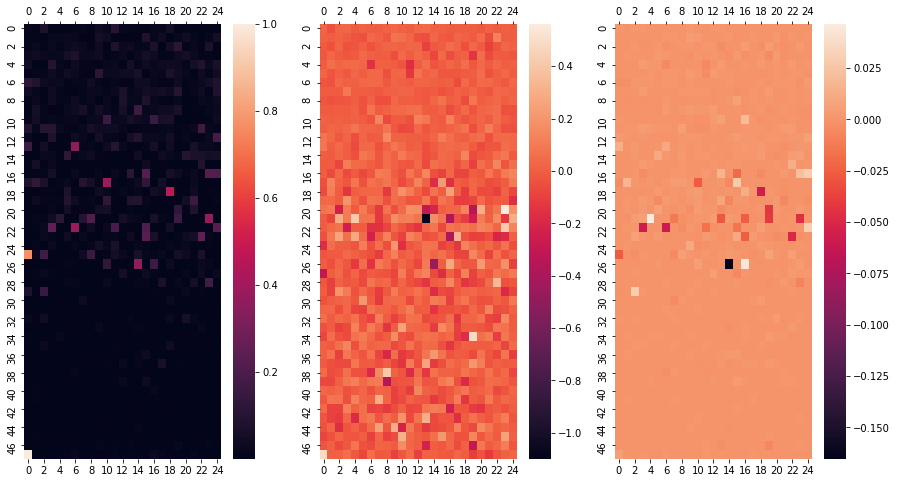

In [555]:
n_rows, n_cols = 1, 3
fig, axs = plt.subplots(n_rows, n_cols, sharey=False, figsize=(5 * n_cols, 2 * 4 * n_rows))
A = [attns, grads, attrs]

for row in range(n_rows):
    for col in range(n_cols):
        ax = axs[row][col] if row > 1 else axs[col]
        a = A[col][:, :, src,tgt].detach()
        if col == 0: a[-1, 0] = 1.
#         fig = plt.subplots(1,1,sharey=False, figsize=(5 , 8))
        ax = sns.heatmap(a, ax=ax)
        ax.tick_params(top=True, labeltop=True)

In [383]:
logits = outputs.logits if hasattr(outputs, 'logits') else outputs[0]
values, indices = logits[0, -1].softmax(dim=-1).topk(5)
list(zip(tokenizer.convert_ids_to_tokens(indices), values.tolist()))

In [132]:
input_ids = tokenizer.encode_plus(_text)['input_ids']
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

input_ids = input_ids[: -3] + input_ids[-2:]
print(tokenizer.convert_ids_to_tokens(input_ids))
outputs = model.generate(torch.LongTensor([input_ids]).to(model.device))
print(_text, tokenizer.decode(outputs[0]))

['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '▁', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1>.</s>
['▁Big', '▁and', '▁small', '▁are', '<extra_id_0>', '.', '</s>']
Big and small are <extra_id_0> . <pad> <extra_id_0> welcome<extra_id_1> welcome.</s>


In [342]:
texts = [
    'Big is to small as fast is to _',
    'Bread is to eat as gun is to _',
    'big: small, fast: _',
    'bread: eat, gun: _ .',
    'flower: fragrant, fire: hot, bread: delicious, gun: _ ',
    'Big and small are _ .',
    'What is twice 3? _.',
    'What is the half 6? _.',
    'There is a sequence: 3, 5, 2, 7. The number immediately precedes 5 is _.',  # :)
    'There is a sequence: 3, 5, 2, 7. The number immediately follows 5 is _.',  # :(
    'There is a sequence: 3, 5, 2, 7. The number between 5 and 7 is _.',
    'There is a sequence of numbers: 3, 5, 2, 4. _ is the first number.',
    'There is a sequence of numbers: 3, 5, 2. The reversed sequence is _.',
    '''There is a sequence of numbers: 5, 1, 6, 3. The second number is 1.
There is a sequence of numbers: 3, 7, 2, 4. The second number is _.''',
    '''There is a sequence of letters: e, c, b, a. The last letter is a.
There is a sequence of letters: f, d, b, g. The last letter is _.''',
    '''The uppercase of c is C. The uppercase of f is _.''',
    '''The successor of 3 is 4. The successor of 8 is _.''',
    '''The successor of 3 is 4. The successor of _ is 6.''',
#     '''The predecessor of 3 is 2. The predecessor of 5 is 4. The predecessor of 6 is _''',
#     '''The previous integer of 4 is 3. The previous integer of 3 is _.''',
#     '''3 minus 1 equals 2. 5 minus 1 equals _.''',
    '''If 2 changes to 3, 5 changes to 6, then _ changes to 9''',
    '''If 2 changes to 20, 3 changes to 30, then 5 changes to _''',
    '''2 -> 3, 4 -> 5, 5 -> 6, 9 -> _.''',
    '''3 -> 2, 5 -> 4, 6 -> 5, 9 -> _''',
    '''9 -> 8, 7 -> 6, 6 -> 5, 2 -> _.''',
    '''3 is to _ as 4 is to 8 and 5 is to 10.''',
#     '''6 : _ :: 5 : 10 :: 7 : 14 :: 8 : 16.''',
#     '''a is to _ as f is to g, h to i, i to j, s to t.''',
#     '''c is to _ as f is to e, h to g, j to i.''',
    '''c is to _ as j is to i, h to g, f to e.''',
#     '''Twice 3 is 6, twice 4 is _.''',
#     '''Half of 4 is 2, half of 6 is _.''',

# '''Shall I compare thee to a summer's day?
# Thou''',
# '''Do not go gentle into that good night,
# Old age should burn and rave at close of day;
# Rage'''
]